In [7]:
%load_ext autoreload

In [8]:
from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

In [9]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [10]:
%autoreload

In [11]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [12]:
data_dir = os.path.join('data', '1.2')

# Environment Setup

In [13]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

# tile_map = [
#         "2FFFUFFF1",
#         "FFFU3UFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUUSUUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_map = [
        "2FFFUFFF1",
        "FFFUUUFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUU3UUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':8.0,
              'S':0.0,
              'U':0.0}


# Enables "texturizing" the environment such that certain areas
# will have greater reward despite being the same tile types
tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.001,0.0,0.0,0.999)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

true_tps = np.array([[[0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 0.999]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.0, 0.999]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.95

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [22]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

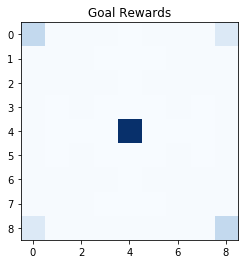

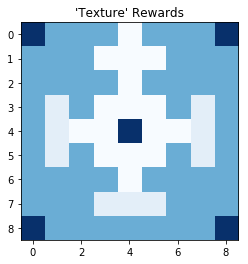

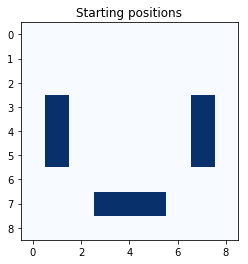

In [25]:
plt.imshow(reward_map, cmap="Blues")
plt.title("Goal Rewards")
plt.show()
plt.imshow(texture_map, cmap="Blues")
plt.title("'Texture' Rewards")
plt.show()

binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")
plt.title("Starting positions")
plt.show()

# Demo visualization tools

In [15]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning for Demonstrations

In [16]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [17]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = logsumexp(prevQ, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [18]:
def tabsoftq_learn_Qs(mdp):
    R = np.repeat(mdp.rewards[np.newaxis].T, 5, axis=1)
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [19]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [20]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


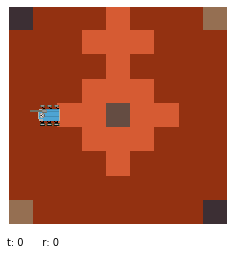

[40.90587517 39.9851597  32.78523731 40.19520364 39.60286986]
0
[0.46262895 0.18423458 0.00013756 0.22729615 0.12570275]
(1, 4) b'S'
(0, 4) b'F'


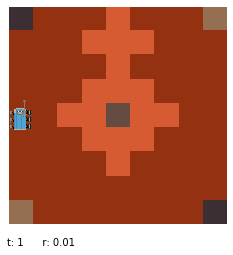

[41.15593853 41.78149652 40.16623378 41.93858075 40.87941309]
3
[0.1616388  0.30214959 0.06007895 0.35354347 0.12258918]
(0, 4) b'F'
(0, 3) b'F'


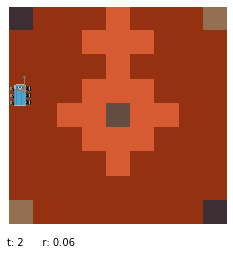

[42.28681633 41.05298492 41.63998227 44.17057605 42.3578671 ]
3
[0.1056334  0.03075779 0.05532034 0.69487667 0.1134118 ]
(0, 3) b'F'
(8, 3) b'F'


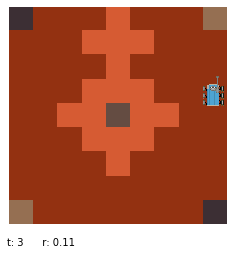

[41.37074246 41.04483627 42.41664472 43.87964327 42.15154352]
3
[0.05251419 0.03790857 0.14945357 0.6454736  0.11465006]
(8, 3) b'F'
(8, 2) b'F'


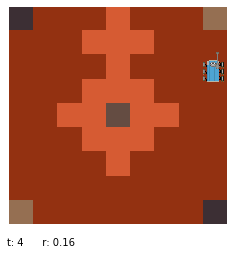

[43.36419585 42.50529549 44.73395369 46.36548256 44.42350953]
3
[0.03526862 0.01494076 0.1387608  0.70930132 0.10172849]
(8, 2) b'F'
(7, 2) b'F'


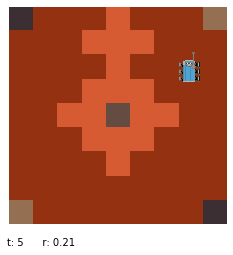

[41.55542586 41.40049344 44.15222506 44.62705007 43.06420471]
3
[0.024169   0.0207001  0.32436523 0.52149262 0.10927305]
(7, 2) b'F'
(7, 1) b'F'


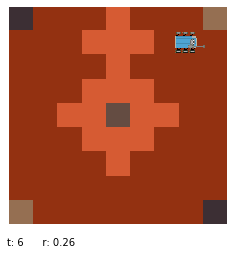

[43.20157137 43.4237397  46.58540767 46.55289839 45.08368508]
2
[0.01496101 0.01868304 0.44110543 0.426996   0.09825453]
(7, 1) b'F'
(8, 1) b'F'


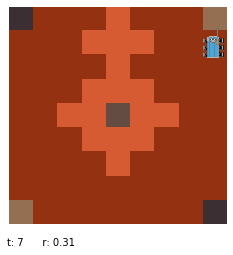

[45.48799602 44.8013515  47.45445091 49.09211989 46.97677736]
3
[0.02006834 0.01009963 0.14339434 0.73750099 0.0889367 ]
(8, 1) b'F'
(8, 0) b'1'


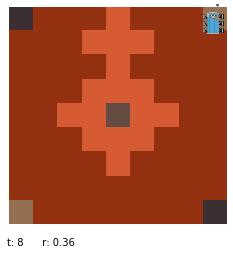

[48.39670968 48.39743461 51.36376655 51.36408858 50.83697002]
3
[0.01910136 0.01911521 0.37122804 0.37134761 0.21920777]
(8, 0) b'1'
(7, 0) b'F'


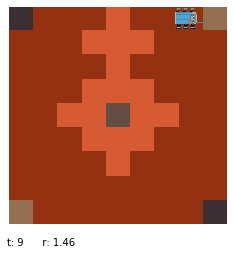

[44.74961338 45.48149645 49.0923783  47.45001859 46.97565307]
2
[0.00960174 0.01996194 0.73856513 0.14292923 0.08894196]
(7, 0) b'F'
(8, 0) b'1'


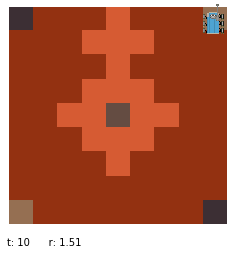

[48.39670968 48.39743461 51.36376655 51.36408858 50.83697002]
3
[0.01910136 0.01911521 0.37122804 0.37134761 0.21920777]
(8, 0) b'1'
(7, 0) b'F'


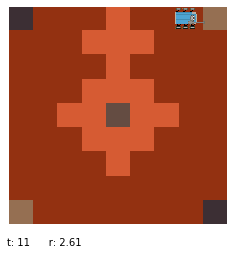

[44.74961338 45.48149645 49.0923783  47.45001859 46.97565307]
2
[0.00960174 0.01996194 0.73856513 0.14292923 0.08894196]
(7, 0) b'F'
(8, 0) b'1'


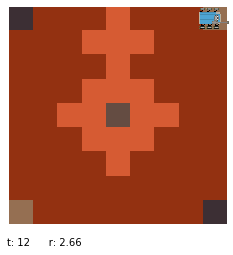

[48.39670968 48.39743461 51.36376655 51.36408858 50.83697002]
2
[0.01910136 0.01911521 0.37122804 0.37134761 0.21920777]
(8, 0) b'1'
(8, 1) b'F'


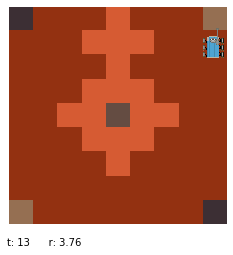

[45.48799602 44.8013515  47.45445091 49.09211989 46.97677736]
3
[0.02006834 0.01009963 0.14339434 0.73750099 0.0889367 ]
(8, 1) b'F'
(0, 1) b'F'


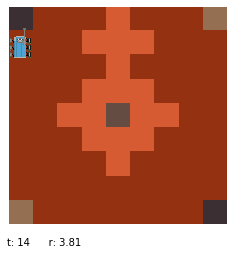

[47.1275095  45.07887899 46.02672481 49.80533671 47.54175369]
3
[0.05705097 0.00735452 0.01897572 0.83028774 0.08633105]
(0, 1) b'F'
(0, 0) b'2'


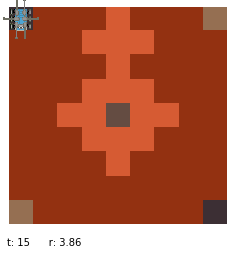

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


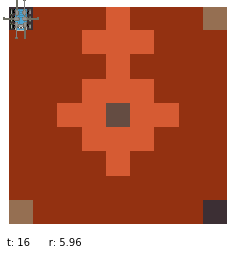

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


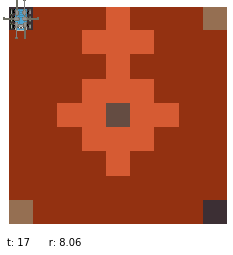

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


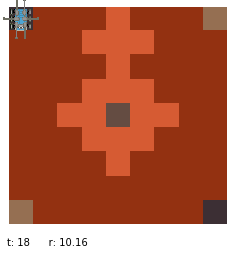

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


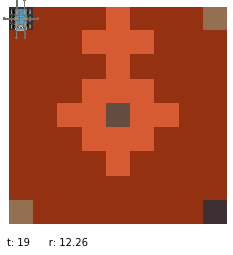

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


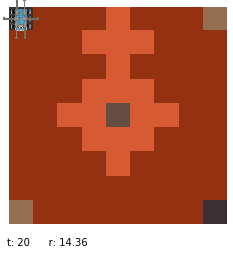

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


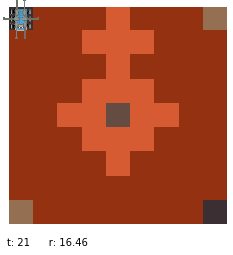

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


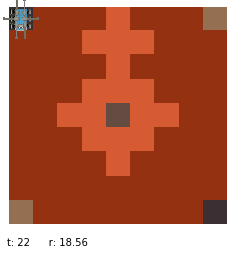

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


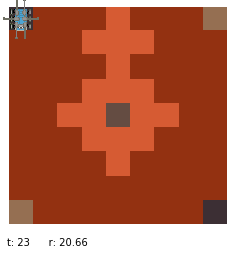

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


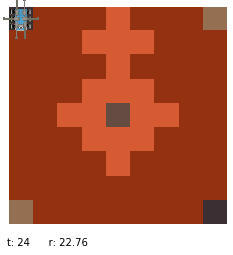

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


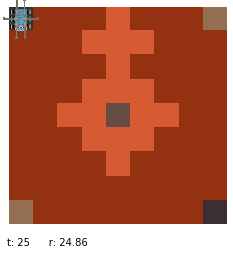

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


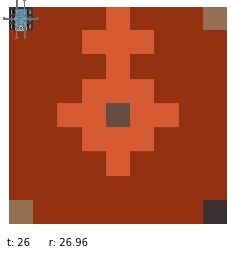

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


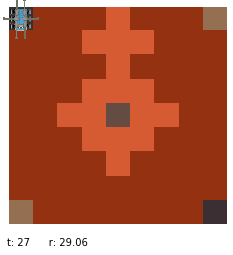

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


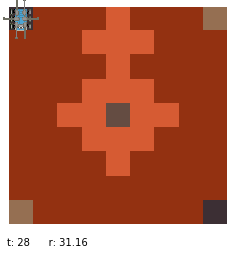

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


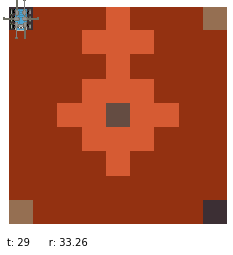

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


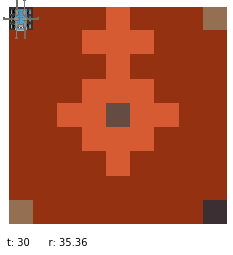

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


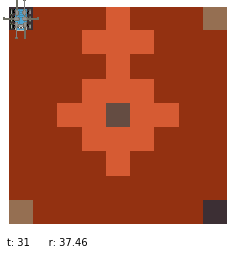

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


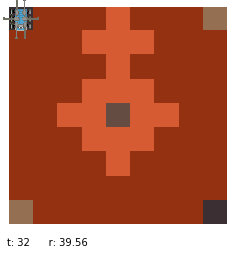

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


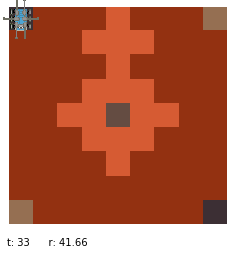

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


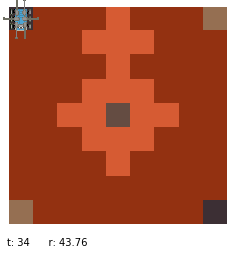

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


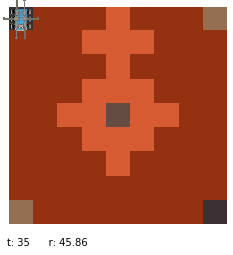

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


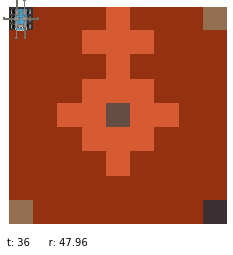

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


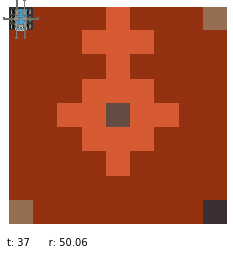

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


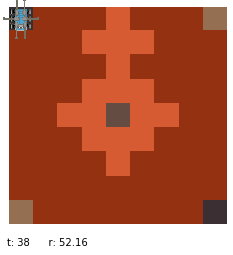

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


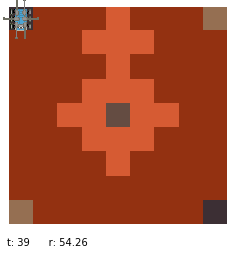

[51.61249402 49.81622858 49.81594703 51.6127667  52.73447416]
4
[0.18508271 0.03070844 0.03069979 0.18513319 0.56837588]
(0, 0) b'2'
(0, 0) b'2'


In [21]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q*50),Qs=Q)


# Model Set Up

In [22]:
train_demo_example_idxes = None
val_demo_example_idxes = None

gamma = 0.99
iterations = 100000
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
batch_size = 512
sq_td_err_penalty = 4
trans_err_penalty = 1


q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 256
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [23]:
n_obs_feats = 2
n_act_dim = 5
featurize_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])
featurize_acts = lambda a: a
n_dirs = 5

In [24]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [25]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    s = np.arange(mdp.nS)
    a = np.arange(mdp.nA) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(feat_states)

    return feat_states, acts_array, rewards, sprimes, tiles

In [26]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######

# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [27]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [28]:
sess = tf.Session()

In [29]:
# Demo placeholders are for the action-likelihood and transition-likelihood portions of the loss
# Constraint placeholders are for the bellman-residual penalty

demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [30]:
# Boltz-beta determines the "rationality" of the agent being modeled. 
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation) * boltz_beta

demo_v_t = tf.reduce_logsumexp(demo_q_t, axis=1)

In [31]:
action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) - demo_v_t

neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [32]:
# Encoded the potential to use "sas" transitions, which are simply state, action, state observations,
# and "adt" transitions -- post-processed to determine (a)ction taken, (d)irection moved, and starting (t)ile-type
# Learning an "adt" transition model should be much easier

sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_t_ph, demo_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [33]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_t_ph, constraint_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [34]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [35]:
# Q-values used to calculate 'V' in the bellman-residual
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))

constraint_v_tp1 = tf.reduce_logsumexp(constraint_q_tp1, axis=2) 

In [36]:
# sas bellman residual penalty error
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
sas_V = tf.multiply(constraint_v_tp1, constraint_sas_pred_probs)
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)


# adt bellman residual penalty error
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
adt_V = tf.multiply(constraint_v_tp1, constraint_adt_pred_probs)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

In [38]:
# sas and adt bellman residual penalty error with a stop gradient on transitions to prevent the bellman update from
# 'hacking' the transition function to overly explain the demonstrations. This happens a lot early on before the
# Q-values have obtained much meaning

sas_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
sas_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V_sg, axis=1)
sas_td_err_sg = tf.reduce_mean((constraint_q_t - sas_target_sg)**2)

adt_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
adt_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sg, axis=1)
adt_td_err_sg = tf.reduce_mean((constraint_q_t - adt_target_sg)**2)

In [39]:
# Total loss function for the sas formulation
sas_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_sas_log_likelihood + sq_td_err_penalty * sas_td_err

# Total loss function for the adt formulation
adt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err

# Loss function for the adt formulation that only optimizes over the q-value approximation 
adt_loss_act_only = neg_avg_act_log_likelihood + sq_td_err_penalty * adt_td_err_sg

# Total loss function for the adt formulation with a stop-gradient on the transition function for the bellman residual
adt_brsgt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err_sg

In [40]:
sas_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(sas_loss)

adt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_loss)

adt_brsgt_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_brsgt_loss)

adt_trans_only_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_adt_log_likelihood)

adt_q_br_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(adt_td_err_sg)

q_nll_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(neg_avg_act_log_likelihood)

In [41]:
# Add in ability to train the q-fn approximator on the true values to test model capacity
true_qs_ph = tf.placeholder(tf.float32, [None], name="tq")
true_q_errs = constraint_q_t - true_qs_ph
true_q_err = tf.reduce_sum((true_q_errs)**2)
true_q_update_op = tf.train.AdamOptimizer(alpha, beta1, beta2).minimize(true_q_err)

In [42]:
def compute_batch_loss(demo_batch, constraints, step=False, update="adt", t=None, true_qs=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    # Naive case of only optimizing over observed transitions -- useful to initialize the dynamics model
    if update == "trans": 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        d = {'loss':trans_likelihood_eval}
    
    # Optimization over the full adt loss function
    if update == "adt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimizing only the q-fn over the bellman residual, equivalent to soft Q-learning
    if update == "adt_br":
        [loss_eval] = sess.run([adt_td_err_sg], feed_dict=feed_dict)
        update_op = adt_q_br_update_op
        d = {'loss': loss_eval}
    
    # Optimization over the full adt loss function with a stop gradient on the dynamics model for the bellman residual
    # Useful in getting the q-fn to match both the observed dynamics and the observed actions taken
    if update == "adt_brsgt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err_sg, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_brsgt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    # Optimization over the full sas loss function
    if update == "sas":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    # For debugging and testing model capacity
    if update == "true_qs":
        feed_dict[true_qs_ph] = true_qs
        [loss_eval] = sess.run([true_q_err], feed_dict=feed_dict)
        update_op = true_q_update_op
        d = {'loss': loss_eval}
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)

    return d

# IDL Experiments

## Demo setup

In [72]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [73]:
def clean_demos(sas_obs, max_noops=15):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > max_noops:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [74]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/mdp.nA

In [75]:
exQs = tabsoftq_learn_Qs(mdp)
# The rationality constant used to generate demos could certainly vary from the one used in the model.....
temp_boltz_beta = 50
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * temp_boltz_beta), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


In [76]:
# Ensure bad areas have not been visited in exes (this is unique to this experiment)
demos = []
while len(demos) < n_demos:
    new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
    more_sas, more_adt = list(zip(*new_demo))
    if len(set([adt[2] for adt in more_adt])) == 1:
        demos += [new_demo]
        
sas_obs, adt_obs = vectorize_rollouts(demos)

In [78]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [64]:
# True q-vals for debugging and comparison purposes
Qs = tabsoftq_learn_Qs(mdp)
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

# Preprocessing for training update visualizations
tts = np.arange(2)
acts = np.arange(mdp.nA) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]
states = featurize_states(np.arange(mdp.nS))

# Optional preloading of q-fn or dynamics models
# q_net_path = os.path.join(data_dir, 'true_q_16384.tf')
# save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, q_scope, q_net_path)

# invadt_path = os.path.join(data_dir, 'adt_invadt_256.tf')
# load_tf_vars(sess, invadt_scope, invadt_path)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


## IDL Training

In [77]:
n_training_iters = 100000

In [62]:
tf.global_variables_initializer().run(session=sess)

In [63]:
full_train_logs = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
}

val_log = None

In [ ]:
# The best order of optimization seems to be "trans" -> "adt_br" -> "adt_brsgt" -> "adt" [->"adt-br"->"adt"]

# update = "trans"
# update = "adt_br"
# update = "adt_brsgt"
update = "adt"

[('ntll', 0.42162454), ('tde', 0.03386261), ('nall', 0.16494906), ('loss', 0.722024)]


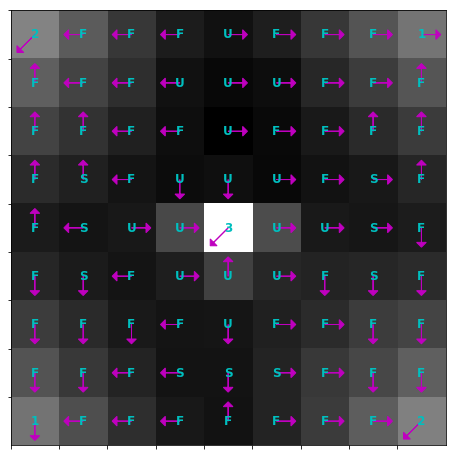

[[0.6335584  0.13696824 0.0203327  0.20913988 0.00000093]
 [0.11494225 0.7468836  0.12913954 0.00903464 0.        ]
 [0.04826052 0.17156404 0.6930725  0.0871029  0.00000004]
 [0.15534115 0.00030539 0.15768455 0.6861387  0.00053019]
 [0.00874302 0.         0.00051708 0.2879463  0.7027936 ]
 [0.00005311 0.0000037  0.00000684 0.00000714 0.9999292 ]
 [0.14423521 0.06170314 0.12017395 0.088245   0.5856427 ]
 [0.20988977 0.04511836 0.20116334 0.13666055 0.407168  ]
 [0.0135099  0.00034871 0.00622338 0.07522318 0.9046948 ]
 [0.00000256 0.         0.00000008 0.00005135 0.999946  ]]


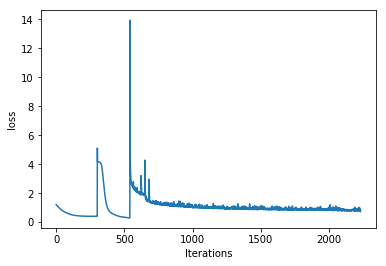

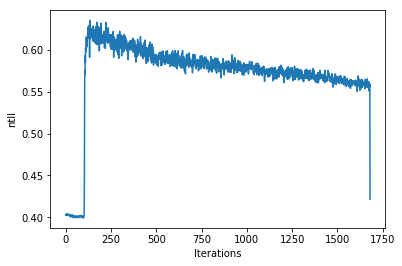

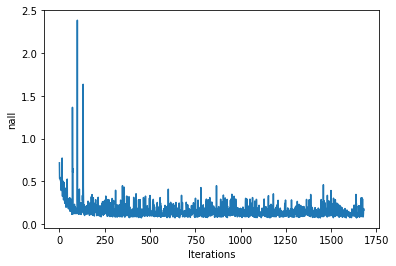

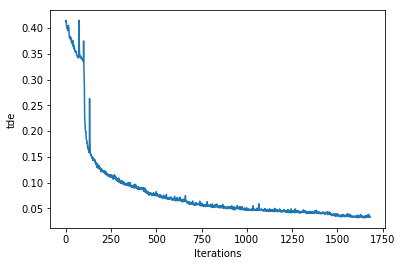

[('ntll', 0.37384117), ('tde', 0.04137873), ('nall', 0.092669934), ('loss', 0.632026)]
[('ntll', 0.38411927), ('tde', 0.036707614), ('nall', 0.076529644), ('loss', 0.6074794)]
[('ntll', 0.3810786), ('tde', 0.036529824), ('nall', 0.079160064), ('loss', 0.60635793)]
[('ntll', 0.3814515), ('tde', 0.036078155), ('nall', 0.10519648), ('loss', 0.6309606)]
[('ntll', 0.37786496), ('tde', 0.035229478), ('nall', 0.10314885), ('loss', 0.62193173)]
[('ntll', 0.3800141), ('tde', 0.033479255), ('nall', 0.08545822), ('loss', 0.5993893)]
[('ntll', 0.38105357), ('tde', 0.03201734), ('nall', 0.07045876), ('loss', 0.5795817)]
[('ntll', 0.38259152), ('tde', 0.03155865), ('nall', 0.08938922), ('loss', 0.59821534)]
[('ntll', 0.38480285), ('tde', 0.029574066), ('nall', 0.05797721), ('loss', 0.5610763)]
[('ntll', 0.3856249), ('tde', 0.029657977), ('nall', 0.1140013), ('loss', 0.6182581)]


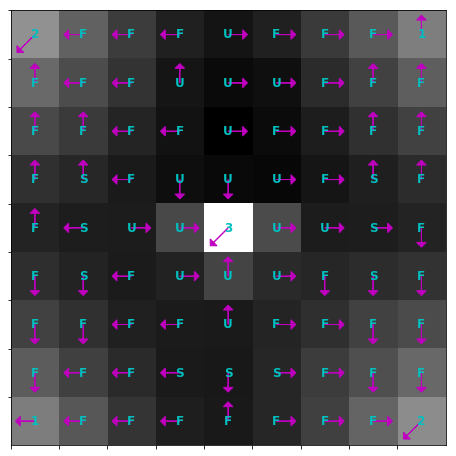

[[0.550104   0.1789227  0.08244032 0.18853003 0.00000294]
 [0.12993912 0.64411575 0.21511966 0.01082551 0.        ]
 [0.07765961 0.23643705 0.5921219  0.09378141 0.00000009]
 [0.22693416 0.00280631 0.17339335 0.5960807  0.00078541]
 [0.00463063 0.0000001  0.00048538 0.21097234 0.7839116 ]
 [0.00002086 0.00000212 0.00000903 0.00000337 0.9999646 ]
 [0.10276216 0.03818185 0.09587406 0.06917145 0.69401056]
 [0.16336033 0.03169871 0.1598557  0.10209023 0.54299504]
 [0.01130511 0.00044986 0.00459335 0.06829198 0.9153597 ]
 [0.00000198 0.         0.00000011 0.00006087 0.99993706]]


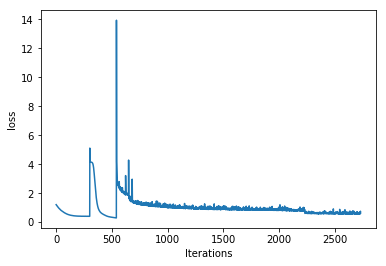

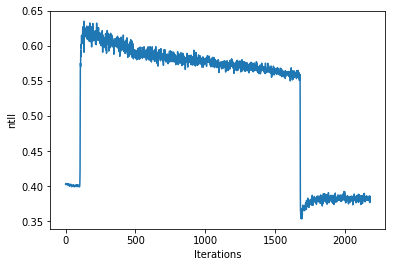

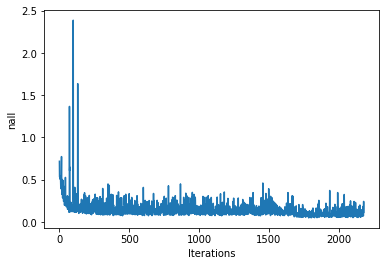

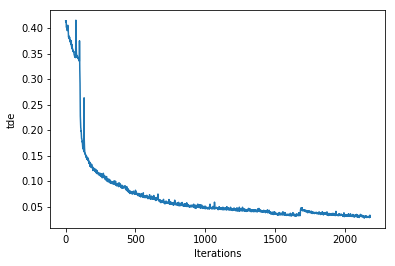

[('ntll', 0.38849506), ('tde', 0.026499456), ('nall', 0.090545796), ('loss', 0.58503866)]
[('ntll', 0.3796582), ('tde', 0.030218428), ('nall', 0.15376359), ('loss', 0.65429544)]
[('ntll', 0.3788534), ('tde', 0.027744817), ('nall', 0.066323), ('loss', 0.5561557)]
[('ntll', 0.3783309), ('tde', 0.027185563), ('nall', 0.07555758), ('loss', 0.5626307)]
[('ntll', 0.3778938), ('tde', 0.026344365), ('nall', 0.07848952), ('loss', 0.5617608)]
[('ntll', 0.3794953), ('tde', 0.025269968), ('nall', 0.08896844), ('loss', 0.5695436)]
[('ntll', 0.37955096), ('tde', 0.024551844), ('nall', 0.06906367), ('loss', 0.546822)]
[('ntll', 0.3772149), ('tde', 0.0245554), ('nall', 0.08724933), ('loss', 0.56268585)]
[('ntll', 0.37588602), ('tde', 0.024950197), ('nall', 0.089164205), ('loss', 0.564851)]
[('ntll', 0.37964103), ('tde', 0.022819268), ('nall', 0.10055219), ('loss', 0.57147026)]


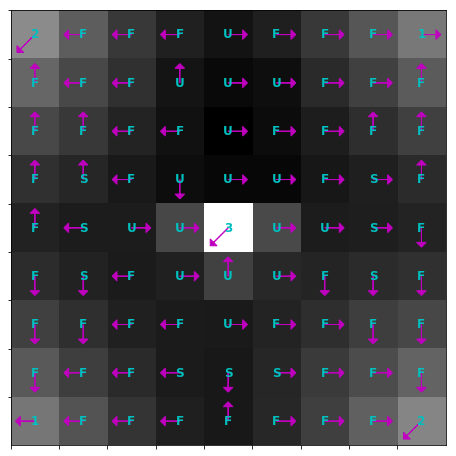

[[0.5465717  0.17454048 0.10151189 0.17737238 0.00000351]
 [0.1283542  0.64477617 0.21624583 0.01062379 0.        ]
 [0.07621852 0.24778825 0.5725532  0.10343985 0.0000001 ]
 [0.22675392 0.01157256 0.16521297 0.5955919  0.00086866]
 [0.00262774 0.00000142 0.00036482 0.20369558 0.7933104 ]
 [0.00001767 0.00000173 0.00000862 0.00000295 0.999969  ]
 [0.09127694 0.03363867 0.08377133 0.06263492 0.7286781 ]
 [0.14622684 0.030322   0.13923952 0.09069075 0.5935209 ]
 [0.00863397 0.00050295 0.00352123 0.06120117 0.92614067]
 [0.00000125 0.         0.00000008 0.00005551 0.99994314]]


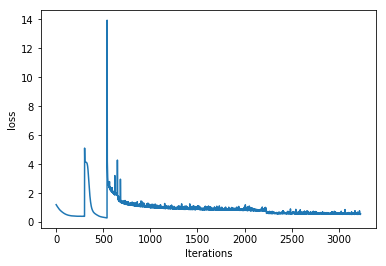

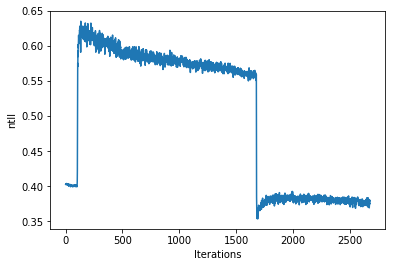

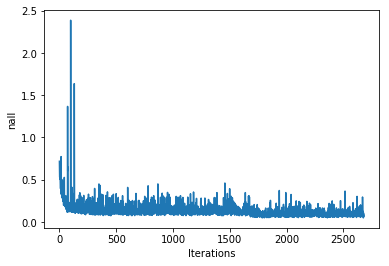

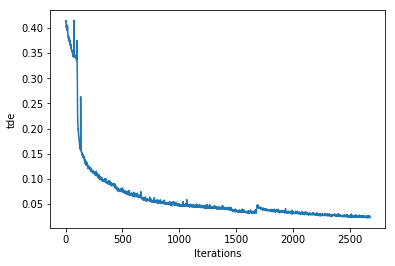

[('ntll', 0.3787974), ('tde', 0.02247352), ('nall', 0.08756886), ('loss', 0.55626035)]
[('ntll', 0.375781), ('tde', 0.027372627), ('nall', 0.17224178), ('loss', 0.65751326)]
[('ntll', 0.3683734), ('tde', 0.024757074), ('nall', 0.14933306), ('loss', 0.61673474)]
[('ntll', 0.3743967), ('tde', 0.022890957), ('nall', 0.13753106), ('loss', 0.6034916)]
[('ntll', 0.3748103), ('tde', 0.021941917), ('nall', 0.156448), ('loss', 0.619026)]
[('ntll', 0.37492427), ('tde', 0.02066411), ('nall', 0.09334497), ('loss', 0.5509257)]
[('ntll', 0.37738734), ('tde', 0.019836452), ('nall', 0.074203), ('loss', 0.5309362)]
[('ntll', 0.36991742), ('tde', 0.021041948), ('nall', 0.0704025), ('loss', 0.52448773)]
[('ntll', 0.37079936), ('tde', 0.0197803), ('nall', 0.07345145), ('loss', 0.52337205)]
[('ntll', 0.37244704), ('tde', 0.0194313), ('nall', 0.10410741), ('loss', 0.5542797)]


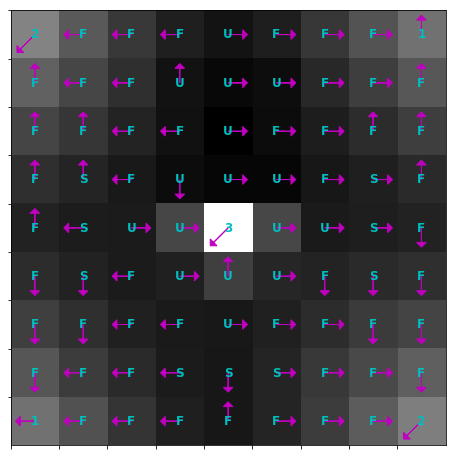

[[0.54979193 0.16923535 0.10624121 0.17472756 0.0000039 ]
 [0.1302761  0.6410305  0.21848091 0.01021243 0.        ]
 [0.07296183 0.24983774 0.570702   0.10649829 0.00000011]
 [0.22207737 0.01849959 0.16241634 0.5960591  0.00094763]
 [0.00165466 0.00000305 0.00028445 0.195548   0.80250984]
 [0.0000154  0.0000014  0.00000782 0.00000259 0.9999728 ]
 [0.08020442 0.028575   0.07568543 0.05614022 0.759395  ]
 [0.1317387  0.02920657 0.12531272 0.08063245 0.63310957]
 [0.00640541 0.0005361  0.00276054 0.05306467 0.93723327]
 [0.00000081 0.         0.00000006 0.0000524  0.9999467 ]]


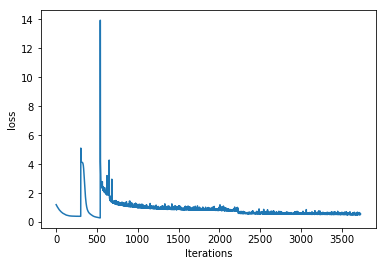

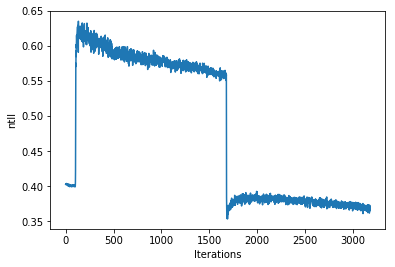

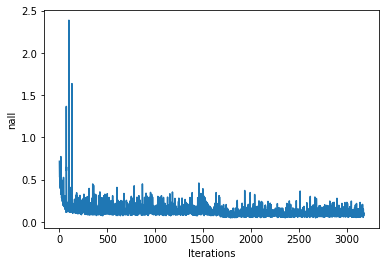

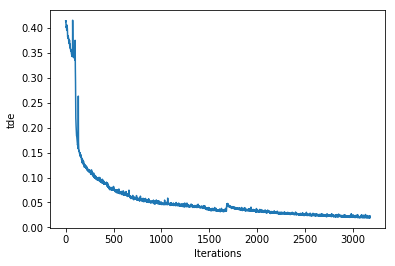

[('ntll', 0.36844483), ('tde', 0.019375646), ('nall', 0.07017974), ('loss', 0.51612717)]
[('ntll', 0.36523005), ('tde', 0.020398106), ('nall', 0.07723844), ('loss', 0.5240609)]
[('ntll', 0.36783686), ('tde', 0.019877033), ('nall', 0.06675277), ('loss', 0.51409775)]
[('ntll', 0.36528957), ('tde', 0.018615374), ('nall', 0.07627988), ('loss', 0.51603097)]
[('ntll', 0.36203983), ('tde', 0.022019636), ('nall', 0.15582472), ('loss', 0.60594314)]
[('ntll', 0.36187157), ('tde', 0.019603414), ('nall', 0.1609213), ('loss', 0.60120654)]
[('ntll', 0.36323267), ('tde', 0.018123306), ('nall', 0.09883533), ('loss', 0.5345612)]
[('ntll', 0.36491865), ('tde', 0.01838993), ('nall', 0.136532), ('loss', 0.57501036)]
[('ntll', 0.36330065), ('tde', 0.017866118), ('nall', 0.12711288), ('loss', 0.561878)]
[('ntll', 0.36606088), ('tde', 0.019260556), ('nall', 0.102217294), ('loss', 0.5453204)]


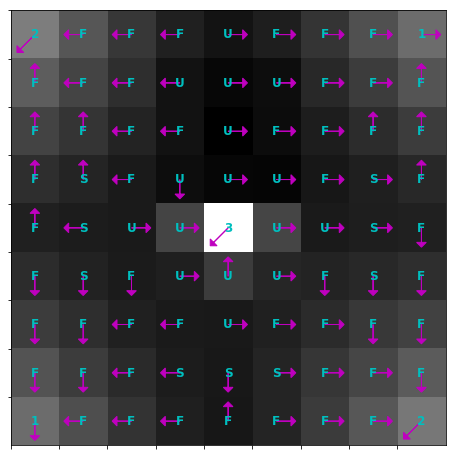

[[0.549034   0.1696275  0.11136829 0.1699659  0.00000429]
 [0.13306518 0.637958   0.21898659 0.00999023 0.        ]
 [0.07278015 0.24653356 0.5670088  0.11367738 0.00000013]
 [0.2177368  0.01501222 0.16377153 0.6024506  0.00102888]
 [0.00115134 0.00000187 0.00025212 0.1883011  0.81029356]
 [0.0000139  0.00000124 0.00000762 0.00000242 0.99997485]
 [0.06997937 0.02509641 0.06824754 0.05214777 0.78452885]
 [0.11141352 0.02650105 0.10898189 0.07349667 0.67960685]
 [0.00477606 0.00049539 0.00225068 0.04637669 0.9461012 ]
 [0.00000058 0.         0.00000005 0.00005056 0.99994886]]


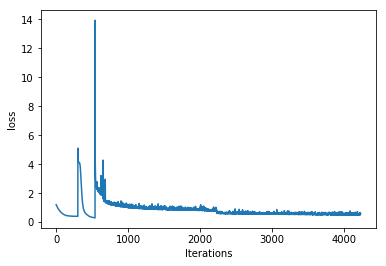

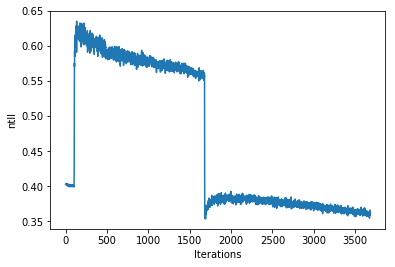

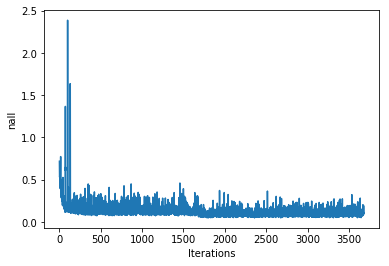

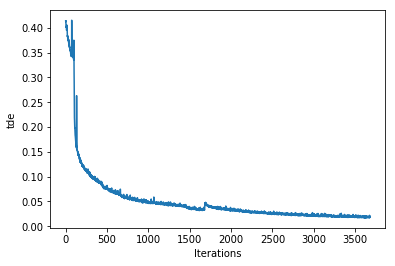

[('ntll', 0.36096662), ('tde', 0.017015744), ('nall', 0.059419554), ('loss', 0.48844916)]
[('ntll', 0.36306742), ('tde', 0.01796354), ('nall', 0.1945542), ('loss', 0.6294758)]
[('ntll', 0.3537558), ('tde', 0.018297184), ('nall', 0.08765436), ('loss', 0.5145989)]
[('ntll', 0.35341063), ('tde', 0.017976763), ('nall', 0.08875018), ('loss', 0.5140679)]
[('ntll', 0.3551088), ('tde', 0.01753728), ('nall', 0.1031286), ('loss', 0.52838653)]
[('ntll', 0.35587406), ('tde', 0.017016916), ('nall', 0.11473034), ('loss', 0.5386721)]
[('ntll', 0.3545817), ('tde', 0.017725723), ('nall', 0.12716688), ('loss', 0.55265146)]
[('ntll', 0.35915655), ('tde', 0.015336933), ('nall', 0.13363156), ('loss', 0.55413586)]
[('ntll', 0.3502555), ('tde', 0.018725296), ('nall', 0.13323328), ('loss', 0.55838996)]
[('ntll', 0.35216638), ('tde', 0.016214257), ('nall', 0.090899065), ('loss', 0.5079225)]


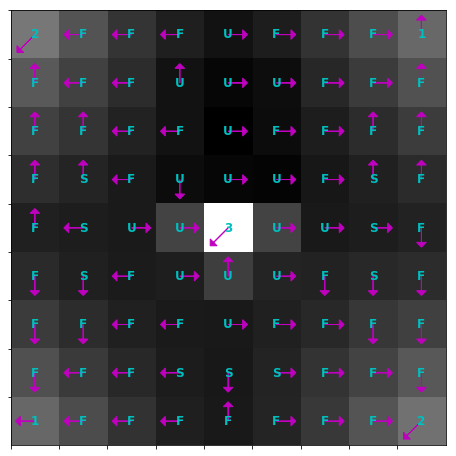

[[0.55700976 0.16721098 0.10936681 0.16640781 0.00000458]
 [0.12928554 0.64309317 0.21841761 0.00920363 0.        ]
 [0.07501169 0.2436933  0.5648642  0.11643072 0.00000014]
 [0.2258938  0.01025624 0.16696595 0.595734   0.00115001]
 [0.00087261 0.0000008  0.00022209 0.17235681 0.82654774]
 [0.00001365 0.00000108 0.00000704 0.00000236 0.9999759 ]
 [0.06470732 0.02213608 0.06111022 0.04942739 0.80261904]
 [0.10027716 0.02362174 0.09501074 0.0657034  0.7153869 ]
 [0.00394077 0.00042066 0.00187307 0.03965355 0.954112  ]
 [0.00000046 0.         0.00000004 0.00004723 0.9999523 ]]


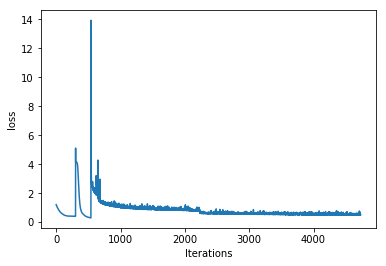

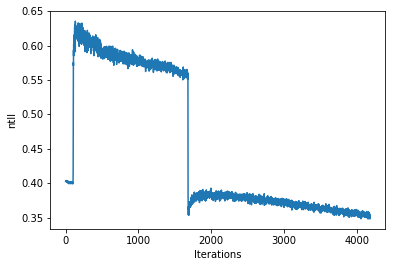

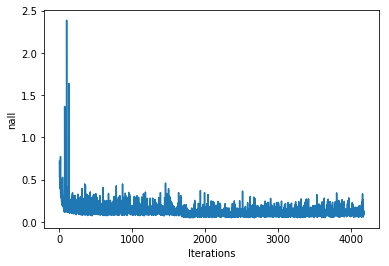

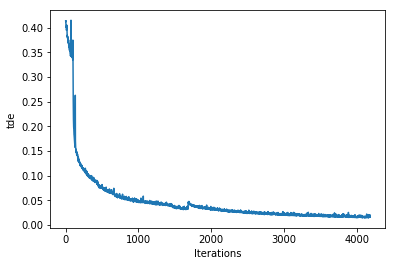

[('ntll', 0.35215238), ('tde', 0.016844207), ('nall', 0.12507875), ('loss', 0.544608)]
[('ntll', 0.3834358), ('tde', 0.051426142), ('nall', 0.10298459), ('loss', 0.69212496)]
[('ntll', 0.3839597), ('tde', 0.036020815), ('nall', 0.085329965), ('loss', 0.6133729)]
[('ntll', 0.3882621), ('tde', 0.03176587), ('nall', 0.09367125), ('loss', 0.60899687)]
[('ntll', 0.3909083), ('tde', 0.02852604), ('nall', 0.10076595), ('loss', 0.6057784)]
[('ntll', 0.38235024), ('tde', 0.028433977), ('nall', 0.0741715), ('loss', 0.57025766)]
[('ntll', 0.38649607), ('tde', 0.026035238), ('nall', 0.13264824), ('loss', 0.62328523)]
[('ntll', 0.38733888), ('tde', 0.02461075), ('nall', 0.112714216), ('loss', 0.5984961)]
[('ntll', 0.37990275), ('tde', 0.026385104), ('nall', 0.16922659), ('loss', 0.65466976)]
[('ntll', 0.3837415), ('tde', 0.023474194), ('nall', 0.10034067), ('loss', 0.57797897)]


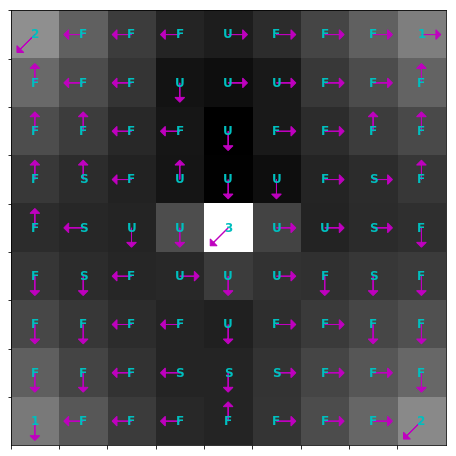

[[0.529863   0.1531586  0.14232089 0.17465256 0.00000497]
 [0.12259768 0.62093943 0.24456401 0.01189882 0.        ]
 [0.0535031  0.26645106 0.554162   0.12588368 0.00000012]
 [0.20543365 0.03730552 0.16514525 0.59119064 0.00092489]
 [0.00091885 0.00001031 0.00024755 0.20127755 0.7975457 ]
 [0.00001451 0.00000095 0.00001308 0.00000253 0.9999689 ]
 [0.05913185 0.01505002 0.08320621 0.04573241 0.79687953]
 [0.06891732 0.00857322 0.059987   0.04378077 0.8187417 ]
 [0.00373999 0.0002897  0.00126817 0.03015901 0.9645431 ]
 [0.00000052 0.         0.00000003 0.00004898 0.9999504 ]]


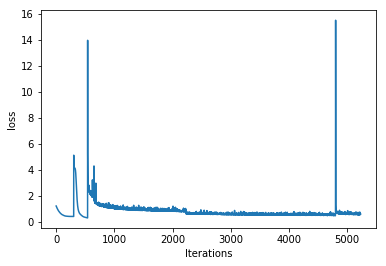

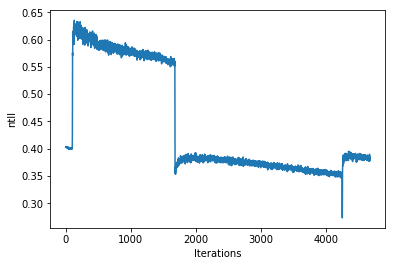

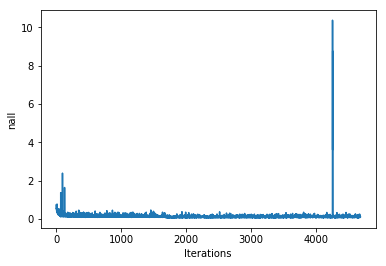

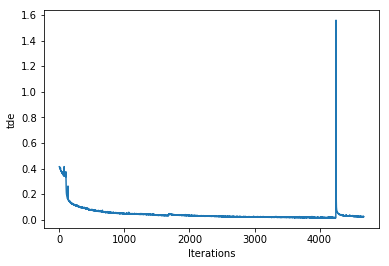

[('ntll', 0.38643977), ('tde', 0.023792071), ('nall', 0.16336946), ('loss', 0.6449775)]
[('ntll', 0.38254023), ('tde', 0.022195235), ('nall', 0.16598637), ('loss', 0.6373075)]
[('ntll', 0.37746492), ('tde', 0.023191845), ('nall', 0.15179022), ('loss', 0.6220225)]
[('ntll', 0.38245845), ('tde', 0.020463668), ('nall', 0.078721285), ('loss', 0.54303443)]
[('ntll', 0.37423348), ('tde', 0.022155387), ('nall', 0.09587639), ('loss', 0.55873144)]
[('ntll', 0.37838733), ('tde', 0.020613555), ('nall', 0.13074462), ('loss', 0.5915862)]
[('ntll', 0.37790927), ('tde', 0.019909415), ('nall', 0.14648438), ('loss', 0.6040313)]
[('ntll', 0.37450373), ('tde', 0.018712023), ('nall', 0.10371364), ('loss', 0.5530655)]
[('ntll', 0.37060016), ('tde', 0.018957315), ('nall', 0.08186249), ('loss', 0.5282919)]
[('ntll', 0.37326348), ('tde', 0.022688031), ('nall', 0.23860078), ('loss', 0.7026164)]


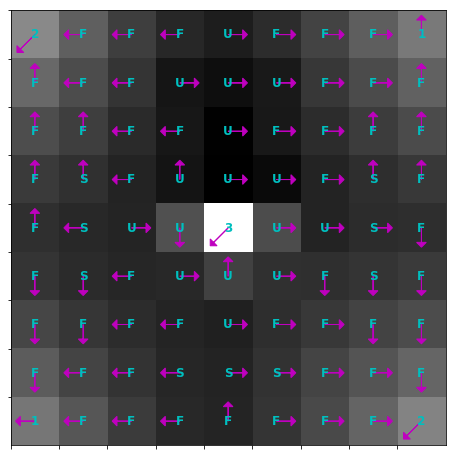

[[0.53277624 0.1477151  0.14504008 0.17446323 0.00000531]
 [0.12684527 0.61674386 0.24397554 0.01243535 0.        ]
 [0.05798545 0.26188982 0.5429175  0.13720708 0.00000013]
 [0.22707497 0.01746327 0.18377437 0.5707021  0.00098539]
 [0.00075018 0.00000206 0.00027805 0.18559776 0.8133719 ]
 [0.00001686 0.00000075 0.000016   0.00000258 0.99996376]
 [0.06802883 0.01169691 0.09107392 0.04744774 0.7817526 ]
 [0.08645318 0.00762116 0.06695963 0.04852739 0.7904386 ]
 [0.00434778 0.00022575 0.00145079 0.03181164 0.96216404]
 [0.00000055 0.         0.00000004 0.00004683 0.99995255]]


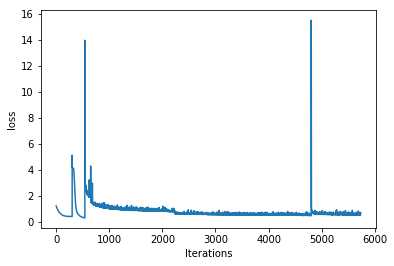

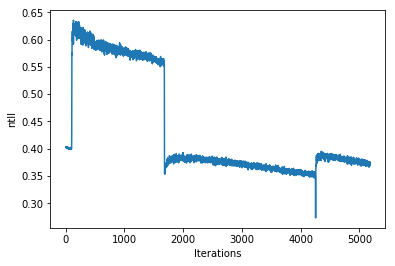

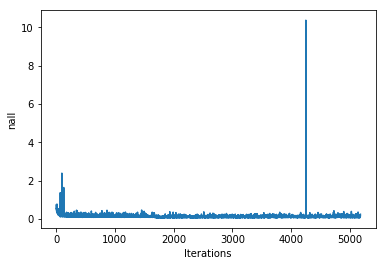

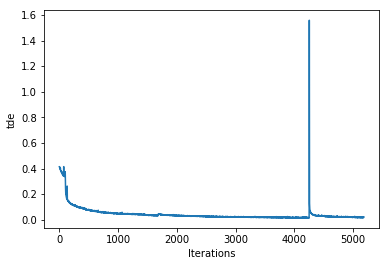

[('ntll', 0.37155697), ('tde', 0.01729039), ('nall', 0.07116305), ('loss', 0.5118816)]
[('ntll', 0.3722129), ('tde', 0.02129591), ('nall', 0.2653325), ('loss', 0.72272897)]
[('ntll', 0.37064612), ('tde', 0.018050157), ('nall', 0.1408185), ('loss', 0.58366525)]
[('ntll', 0.3677499), ('tde', 0.017181264), ('nall', 0.11470109), ('loss', 0.5511761)]
[('ntll', 0.36935076), ('tde', 0.015551193), ('nall', 0.09943611), ('loss', 0.5309916)]
[('ntll', 0.3698196), ('tde', 0.017240824), ('nall', 0.24281304), ('loss', 0.6815959)]
[('ntll', 0.36510366), ('tde', 0.01532158), ('nall', 0.08161047), ('loss', 0.50800043)]
[('ntll', 0.36137784), ('tde', 0.016865134), ('nall', 0.14630887), ('loss', 0.5751473)]
[('ntll', 0.36492828), ('tde', 0.0158461), ('nall', 0.12278136), ('loss', 0.55109406)]
[('ntll', 0.36652154), ('tde', 0.014715104), ('nall', 0.14324416), ('loss', 0.5686261)]


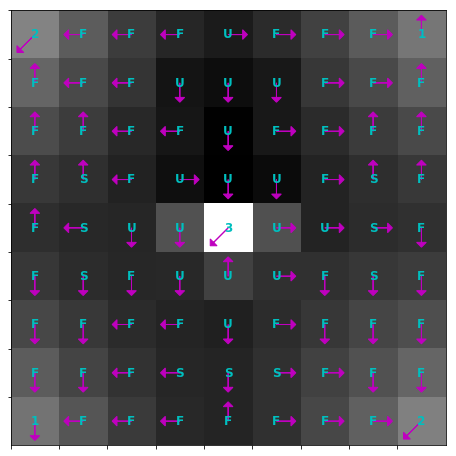

[[0.5316575  0.15149131 0.14529662 0.17154886 0.00000567]
 [0.12904616 0.6250956  0.23388588 0.01197234 0.        ]
 [0.05882528 0.2570804  0.5382419  0.1458523  0.00000015]
 [0.2239128  0.01016819 0.18183602 0.5830171  0.00106587]
 [0.00052338 0.00000065 0.00023041 0.1807105  0.8185351 ]
 [0.00001572 0.00000058 0.00001541 0.00000225 0.999966  ]
 [0.06348397 0.00945153 0.08178645 0.04191094 0.8033671 ]
 [0.09042805 0.00943967 0.07120512 0.05032327 0.77860385]
 [0.00466601 0.00027264 0.00157237 0.03235247 0.96113646]
 [0.00000047 0.         0.00000004 0.00004279 0.9999567 ]]


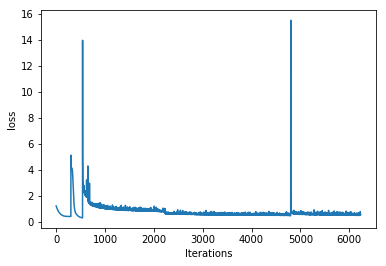

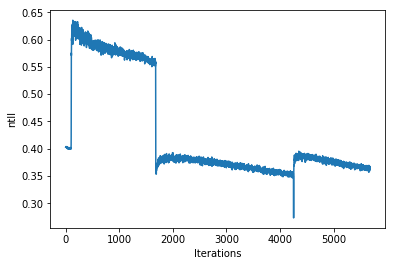

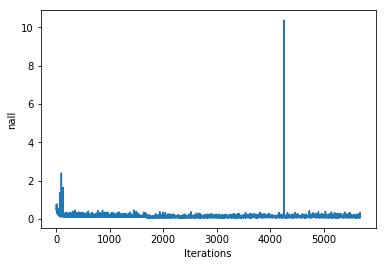

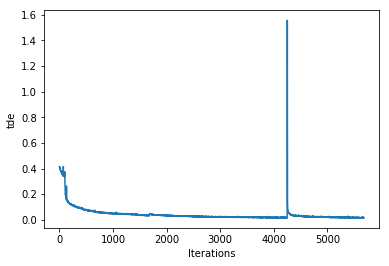

[('ntll', 0.3648013), ('tde', 0.015963625), ('nall', 0.15950146), ('loss', 0.58815724)]
[('ntll', 0.36262217), ('tde', 0.014219923), ('nall', 0.10981603), ('loss', 0.5293179)]
[('ntll', 0.35892257), ('tde', 0.016534112), ('nall', 0.17786713), ('loss', 0.60292614)]
[('ntll', 0.36199144), ('tde', 0.013654716), ('nall', 0.06679553), ('loss', 0.48340583)]
[('ntll', 0.35649243), ('tde', 0.016223373), ('nall', 0.17792113), ('loss', 0.59930706)]
[('ntll', 0.36021596), ('tde', 0.013561292), ('nall', 0.06858439), ('loss', 0.48304552)]
[('ntll', 0.35811344), ('tde', 0.0143130915), ('nall', 0.07177059), ('loss', 0.4871364)]
[('ntll', 0.35409835), ('tde', 0.0138353985), ('nall', 0.080438145), ('loss', 0.4898781)]
[('ntll', 0.35334247), ('tde', 0.013856479), ('nall', 0.105588004), ('loss', 0.51435643)]
[('ntll', 0.3543617), ('tde', 0.016345285), ('nall', 0.15425412), ('loss', 0.573997)]


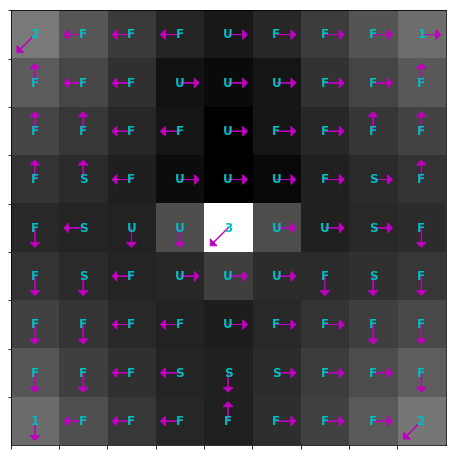

[[0.5408104  0.14742626 0.15523644 0.15652077 0.00000614]
 [0.13135363 0.62697417 0.23138565 0.01028652 0.        ]
 [0.06263159 0.25356314 0.538726   0.14507915 0.00000017]
 [0.21840413 0.00706331 0.19175039 0.58156943 0.00121275]
 [0.0003443  0.00000027 0.00020373 0.16626045 0.8331913 ]
 [0.00001279 0.00000039 0.00001392 0.00000175 0.99997115]
 [0.05320437 0.0079788  0.07045829 0.03488924 0.8334693 ]
 [0.08352607 0.01238336 0.07233831 0.04831885 0.78343344]
 [0.00391158 0.0003518  0.00154268 0.0294641  0.9647299 ]
 [0.00000033 0.         0.00000004 0.00003766 0.999962  ]]


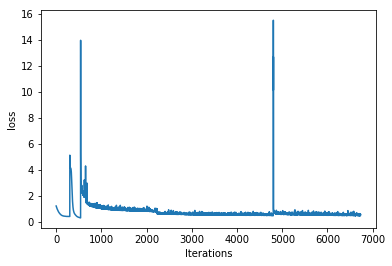

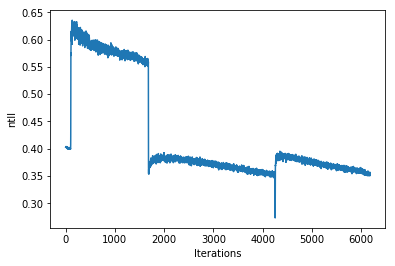

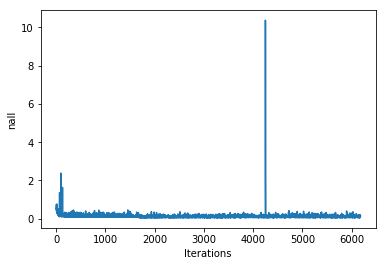

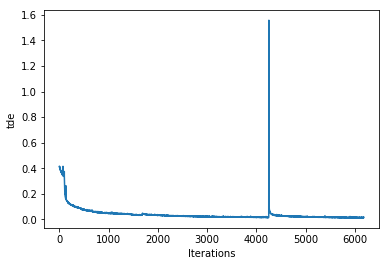

[('ntll', 0.35118437), ('tde', 0.015098619), ('nall', 0.10419517), ('loss', 0.515774)]
[('ntll', 0.35043186), ('tde', 0.013041631), ('nall', 0.10246031), ('loss', 0.5050587)]
[('ntll', 0.3562109), ('tde', 0.011276802), ('nall', 0.087085076), ('loss', 0.48840317)]
[('ntll', 0.35328537), ('tde', 0.013270909), ('nall', 0.2718804), ('loss', 0.6782494)]
[('ntll', 0.3524539), ('tde', 0.017077), ('nall', 0.2533707), ('loss', 0.6741326)]
[('ntll', 0.34825704), ('tde', 0.0121656405), ('nall', 0.07379122), ('loss', 0.47071084)]
[('ntll', 0.34797826), ('tde', 0.013905126), ('nall', 0.14089727), ('loss', 0.54449606)]
[('ntll', 0.34631723), ('tde', 0.013349475), ('nall', 0.12761916), ('loss', 0.5273343)]
[('ntll', 0.34911117), ('tde', 0.011510494), ('nall', 0.09752349), ('loss', 0.49267662)]
[('ntll', 0.34610355), ('tde', 0.012323122), ('nall', 0.09391651), ('loss', 0.48931253)]


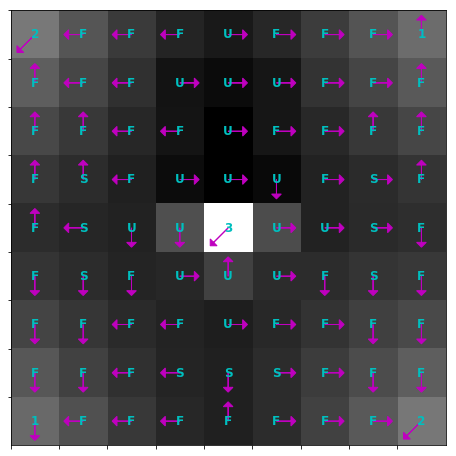

[[0.5393463  0.15311433 0.14919405 0.15833914 0.00000624]
 [0.13473132 0.63310117 0.2232677  0.00889981 0.        ]
 [0.07090008 0.24638103 0.53259593 0.15012279 0.00000019]
 [0.21218765 0.00407636 0.17847583 0.6038826  0.00137748]
 [0.00023343 0.00000008 0.00015023 0.15969607 0.83992016]
 [0.00001237 0.00000039 0.0000139  0.00000184 0.9999715 ]
 [0.05438308 0.00845475 0.07193824 0.03606278 0.8291611 ]
 [0.08590218 0.01241951 0.07502446 0.05109725 0.7755566 ]
 [0.00349078 0.00029313 0.00147681 0.03115681 0.96358246]
 [0.00000024 0.         0.00000003 0.00003979 0.99995995]]


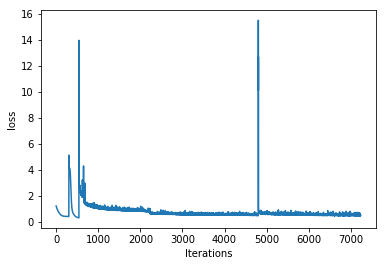

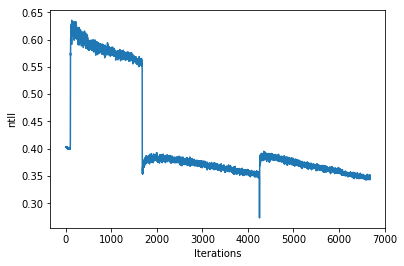

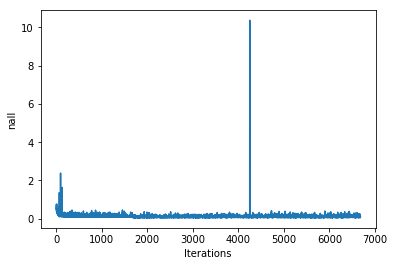

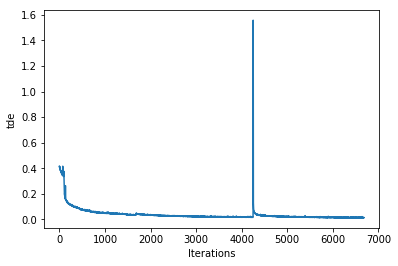

[('ntll', 0.34594342), ('tde', 0.012019704), ('nall', 0.07036425), ('loss', 0.4643865)]
[('ntll', 0.34611884), ('tde', 0.016623233), ('nall', 0.17437716), ('loss', 0.5869889)]
[('ntll', 0.34693766), ('tde', 0.011186864), ('nall', 0.09931686), ('loss', 0.49100196)]
[('ntll', 0.34290868), ('tde', 0.012723852), ('nall', 0.07985536), ('loss', 0.47365946)]
[('ntll', 0.34578457), ('tde', 0.0109638395), ('nall', 0.067070045), ('loss', 0.45670998)]
[('ntll', 0.34316275), ('tde', 0.012771735), ('nall', 0.1476972), ('loss', 0.5419469)]
[('ntll', 0.3420221), ('tde', 0.012383084), ('nall', 0.107424125), ('loss', 0.49897853)]
[('ntll', 0.34106714), ('tde', 0.0114612905), ('nall', 0.074475266), ('loss', 0.46138754)]
[('ntll', 0.3420889), ('tde', 0.010979172), ('nall', 0.12913351), ('loss', 0.5151391)]
[('ntll', 0.34722775), ('tde', 0.011389622), ('nall', 0.1000189), ('loss', 0.49280515)]


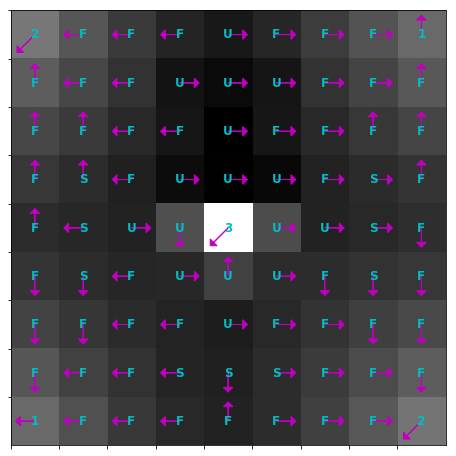

[[0.5357866  0.15637758 0.147247   0.16058241 0.00000646]
 [0.13015573 0.64009416 0.22218965 0.0075605  0.        ]
 [0.07265288 0.24783754 0.5365975  0.14291188 0.0000002 ]
 [0.208747   0.00310379 0.18685988 0.5998768  0.00141247]
 [0.00018613 0.00000004 0.0001443  0.16163208 0.83803743]
 [0.00001076 0.00000033 0.00001237 0.00000183 0.9999747 ]
 [0.04705223 0.00750501 0.06450664 0.03353093 0.8474052 ]
 [0.07526528 0.01168995 0.07164112 0.04531288 0.79609084]
 [0.0028413  0.00028197 0.00142317 0.0287399  0.9667136 ]
 [0.00000019 0.         0.00000003 0.00004028 0.99995947]]


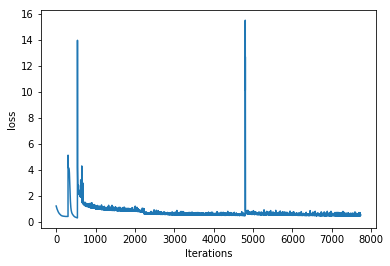

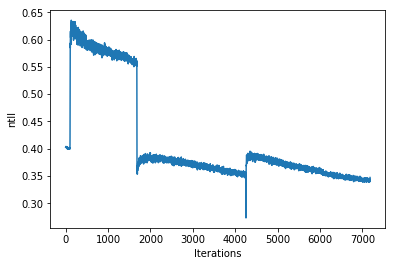

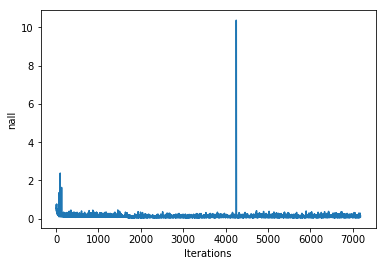

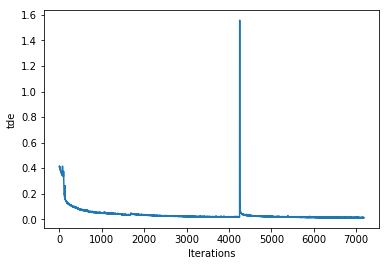

[('ntll', 0.34293157), ('tde', 0.011520553), ('nall', 0.123926684), ('loss', 0.51294047)]
[('ntll', 0.34234247), ('tde', 0.0105025135), ('nall', 0.10737237), ('loss', 0.4917249)]
[('ntll', 0.33759895), ('tde', 0.01134625), ('nall', 0.06035111), ('loss', 0.44333506)]
[('ntll', 0.33821946), ('tde', 0.020910325), ('nall', 0.281664), ('loss', 0.70352477)]
[('ntll', 0.34010938), ('tde', 0.010519597), ('nall', 0.060873147), ('loss', 0.4430609)]
[('ntll', 0.33421898), ('tde', 0.015406476), ('nall', 0.2787951), ('loss', 0.67464)]
[('ntll', 0.34576666), ('tde', 0.014451064), ('nall', 0.11063058), ('loss', 0.5142015)]
[('ntll', 0.33948535), ('tde', 0.011235374), ('nall', 0.10951451), ('loss', 0.49394134)]
[('ntll', 0.33819464), ('tde', 0.010645301), ('nall', 0.067058794), ('loss', 0.44783464)]
[('ntll', 0.33703843), ('tde', 0.010295239), ('nall', 0.08155647), ('loss', 0.45977587)]


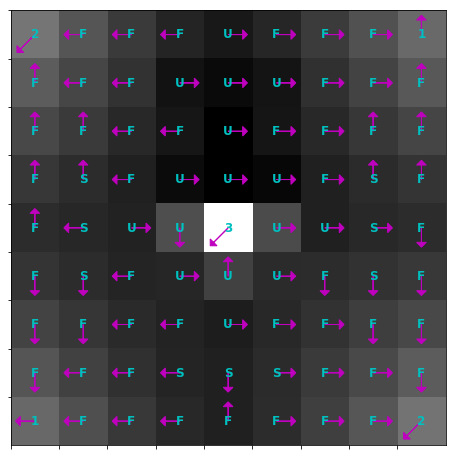

[[0.5402333  0.15783204 0.14065525 0.1612731  0.00000629]
 [0.13481571 0.6382769  0.21997274 0.00693466 0.        ]
 [0.08198867 0.23391992 0.5326312  0.15146002 0.00000023]
 [0.2097311  0.00204049 0.16998354 0.61666596 0.00157889]
 [0.00014682 0.00000002 0.00010667 0.15115708 0.84858936]
 [0.00001102 0.00000032 0.00001223 0.00000195 0.9999745 ]
 [0.04969335 0.00761305 0.06512016 0.03500902 0.84256446]
 [0.08126014 0.01232197 0.07436345 0.0492911  0.7827633 ]
 [0.00267575 0.00026121 0.00132445 0.02879112 0.9669475 ]
 [0.00000016 0.         0.00000003 0.00004026 0.9999596 ]]


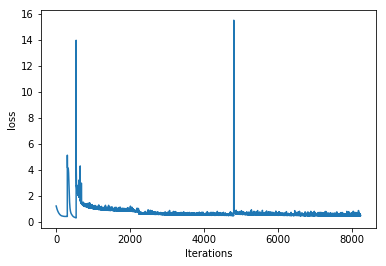

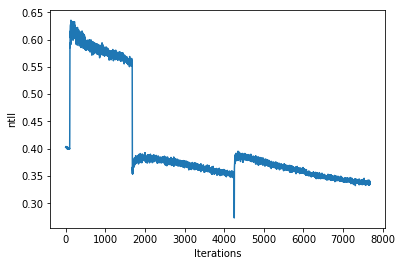

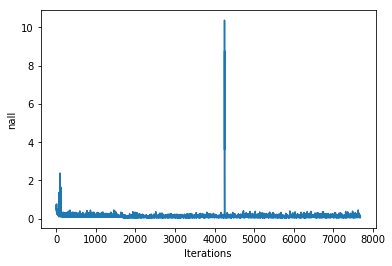

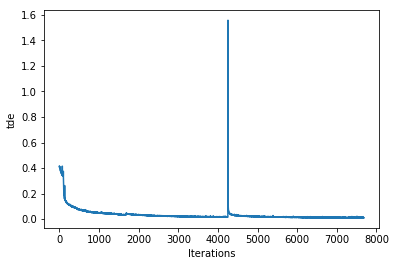

[('ntll', 0.33987916), ('tde', 0.01014698), ('nall', 0.091342345), ('loss', 0.47180942)]
[('ntll', 0.3347747), ('tde', 0.0135757085), ('nall', 0.23038775), ('loss', 0.61946523)]
[('ntll', 0.33557564), ('tde', 0.012365649), ('nall', 0.09139635), ('loss', 0.47643456)]
[('ntll', 0.33291855), ('tde', 0.0111352615), ('nall', 0.06073139), ('loss', 0.438191)]
[('ntll', 0.33540323), ('tde', 0.011917232), ('nall', 0.15368484), ('loss', 0.536757)]
[('ntll', 0.33272365), ('tde', 0.011207968), ('nall', 0.10318261), ('loss', 0.48073813)]
[('ntll', 0.3352167), ('tde', 0.010540375), ('nall', 0.14933306), ('loss', 0.5267113)]
[('ntll', 0.33108696), ('tde', 0.012820814), ('nall', 0.14937581), ('loss', 0.53174603)]
[('ntll', 0.33349848), ('tde', 0.010441138), ('nall', 0.07432225), ('loss', 0.4495853)]
[('ntll', 0.33425882), ('tde', 0.010143831), ('nall', 0.104397684), ('loss', 0.47923183)]


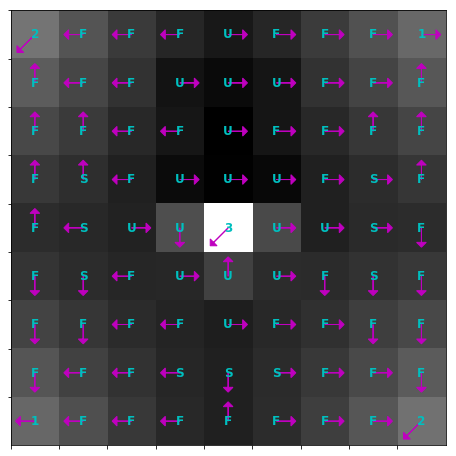

[[0.5416116  0.16130643 0.13781185 0.15926397 0.00000614]
 [0.13621987 0.6414693  0.21618609 0.0061247  0.        ]
 [0.08689816 0.23011267 0.5365542  0.14643466 0.00000023]
 [0.21150084 0.00159483 0.17295921 0.612328   0.00161714]
 [0.0001239  0.00000001 0.00009874 0.14806175 0.85171556]
 [0.00001048 0.0000003  0.00001175 0.00000203 0.99997544]
 [0.04772586 0.00751345 0.06224412 0.03481461 0.84770197]
 [0.07970924 0.01264458 0.07276609 0.04858049 0.7862996 ]
 [0.00266682 0.00027124 0.00136611 0.02706508 0.9686308 ]
 [0.00000014 0.         0.00000003 0.00003863 0.99996126]]


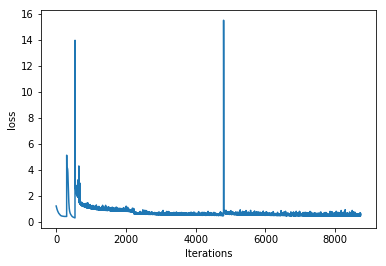

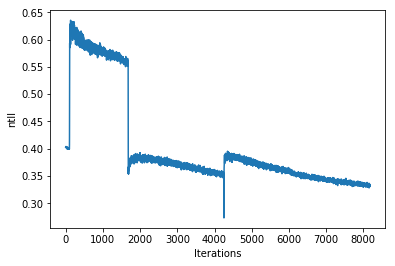

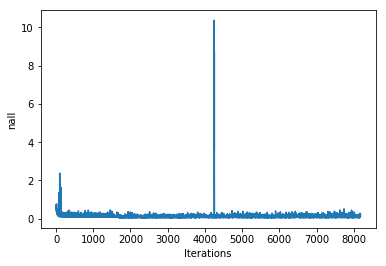

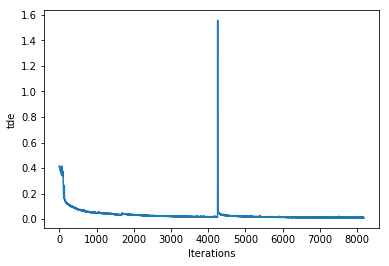

[('ntll', 0.33446568), ('tde', 0.009932802), ('nall', 0.10633056), ('loss', 0.48052746)]
[('ntll', 0.33352283), ('tde', 0.010482609), ('nall', 0.1251845), ('loss', 0.50063777)]
[('ntll', 0.3314827), ('tde', 0.010396695), ('nall', 0.14203809), ('loss', 0.5151076)]
[('ntll', 0.33024424), ('tde', 0.010243636), ('nall', 0.06906367), ('loss', 0.44028246)]
[('ntll', 0.3316817), ('tde', 0.009996911), ('nall', 0.056613624), ('loss', 0.42828298)]
[('ntll', 0.3294157), ('tde', 0.010387225), ('nall', 0.10119347), ('loss', 0.47215807)]
[('ntll', 0.33114338), ('tde', 0.01002347), ('nall', 0.077872984), ('loss', 0.44911024)]
[('ntll', 0.33431497), ('tde', 0.010175885), ('nall', 0.17540547), ('loss', 0.550424)]
[('ntll', 0.3342624), ('tde', 0.009785239), ('nall', 0.07149158), ('loss', 0.4448949)]
[('ntll', 0.32501462), ('tde', 0.017992748), ('nall', 0.18932712), ('loss', 0.5863127)]


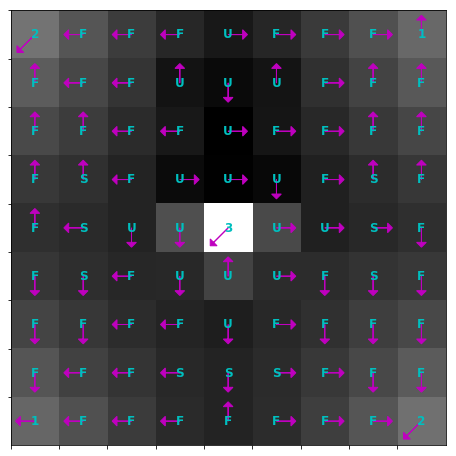

[[0.5450588  0.1618795  0.13353056 0.15952507 0.0000061 ]
 [0.13906996 0.64195126 0.21332452 0.00565422 0.        ]
 [0.09084529 0.23108505 0.5325936  0.14547585 0.00000024]
 [0.2123781  0.00134072 0.17169553 0.6128423  0.00174336]
 [0.00010608 0.00000001 0.00008703 0.13634893 0.863458  ]
 [0.00000986 0.00000027 0.00001113 0.0000021  0.99997663]
 [0.04502929 0.00713135 0.0593284  0.03493302 0.8535779 ]
 [0.07930394 0.01326435 0.07400765 0.04852065 0.7849034 ]
 [0.00264736 0.0002869  0.00144325 0.024618   0.9710045 ]
 [0.00000013 0.         0.00000003 0.0000356  0.99996424]]


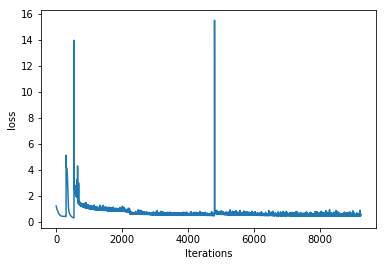

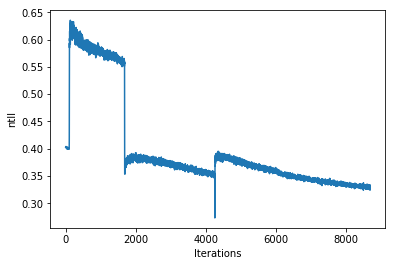

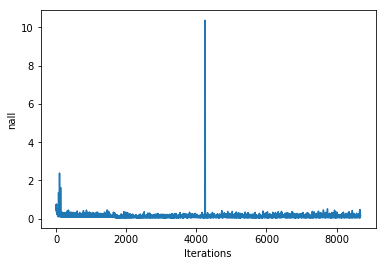

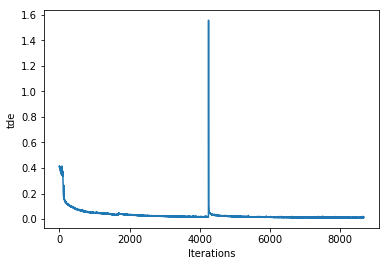

[('ntll', 0.32753417), ('tde', 0.016801914), ('nall', 0.22973971), ('loss', 0.6244815)]
[('ntll', 0.32959744), ('tde', 0.009549448), ('nall', 0.09448805), ('loss', 0.46228328)]
[('ntll', 0.32567298), ('tde', 0.010944327), ('nall', 0.11119311), ('loss', 0.48064342)]
[('ntll', 0.3286925), ('tde', 0.013151984), ('nall', 0.2398271), ('loss', 0.62112755)]
[('ntll', 0.32500452), ('tde', 0.010217536), ('nall', 0.07376647), ('loss', 0.43964112)]
[('ntll', 0.32616138), ('tde', 0.009949363), ('nall', 0.07168734), ('loss', 0.43764618)]
[('ntll', 0.3254849), ('tde', 0.0119461175), ('nall', 0.21597107), ('loss', 0.58924043)]
[('ntll', 0.32453424), ('tde', 0.010139448), ('nall', 0.06887016), ('loss', 0.4339622)]
[('ntll', 0.32579857), ('tde', 0.010507108), ('nall', 0.09555461), ('loss', 0.46338162)]
[('ntll', 0.32759118), ('tde', 0.010016919), ('nall', 0.07125756), ('loss', 0.43891641)]


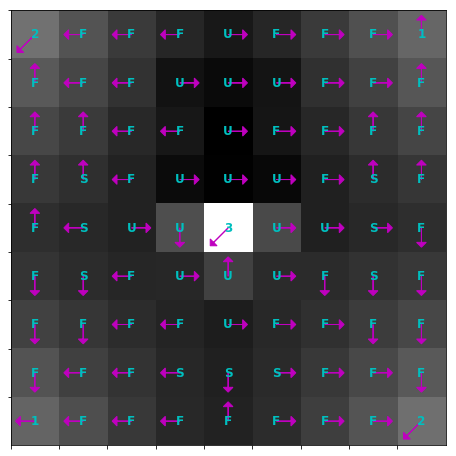

[[0.5480265  0.16219938 0.12879667 0.16097155 0.00000586]
 [0.14078893 0.645118   0.20879957 0.00529346 0.        ]
 [0.09472975 0.22618672 0.5321315  0.14695181 0.00000023]
 [0.21427688 0.00104588 0.1660367  0.61696255 0.00167802]
 [0.00010071 0.00000001 0.00008069 0.1414684  0.85835016]
 [0.00001045 0.00000028 0.00001152 0.00000233 0.99997544]
 [0.04806058 0.00766936 0.0623938  0.03705052 0.8448258 ]
 [0.08563879 0.01436599 0.07828077 0.05135092 0.77036357]
 [0.00349303 0.00034331 0.00186874 0.02667062 0.9676243 ]
 [0.00000016 0.         0.00000003 0.00003861 0.99996114]]


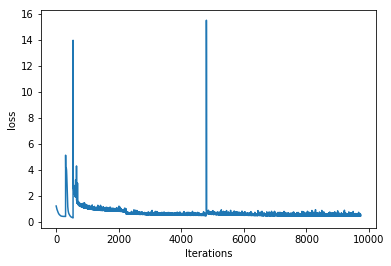

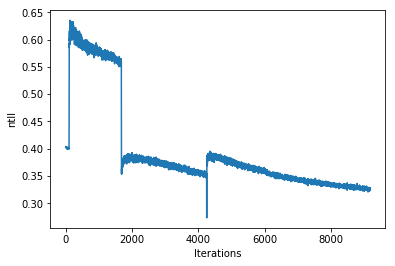

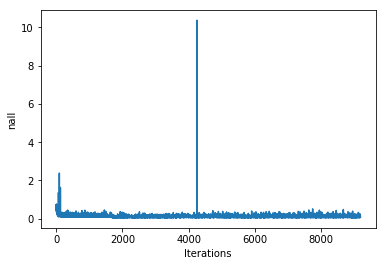

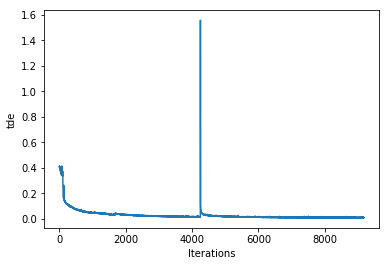

[('ntll', 0.3254074), ('tde', 0.009106476), ('nall', 0.06777209), ('loss', 0.42960536)]
[('ntll', 0.32198334), ('tde', 0.0103497), ('nall', 0.11971441), ('loss', 0.48309654)]
[('ntll', 0.3247836), ('tde', 0.010302383), ('nall', 0.14669813), ('loss', 0.51269126)]
[('ntll', 0.3252081), ('tde', 0.009729442), ('nall', 0.14936231), ('loss', 0.5134882)]
[('ntll', 0.32171017), ('tde', 0.009552108), ('nall', 0.072699904), ('loss', 0.4326185)]
[('ntll', 0.3213877), ('tde', 0.01015361), ('nall', 0.07343795), ('loss', 0.43544012)]
[('ntll', 0.32362264), ('tde', 0.01114716), ('nall', 0.22959119), ('loss', 0.59780246)]
[('ntll', 0.32341278), ('tde', 0.01131155), ('nall', 0.19597179), ('loss', 0.56463075)]
[('ntll', 0.32255012), ('tde', 0.00929543), ('nall', 0.09593489), ('loss', 0.45566672)]
[('ntll', 0.3260963), ('tde', 0.009148132), ('nall', 0.14549206), ('loss', 0.5081809)]


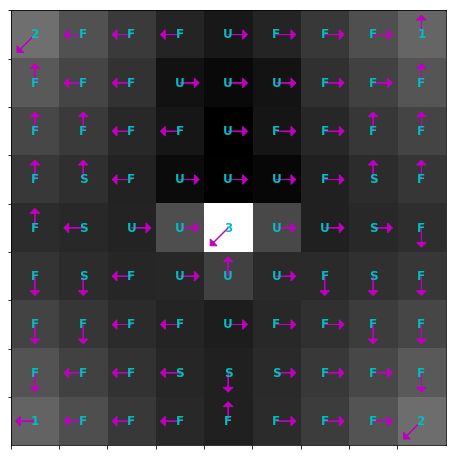

[[0.54743654 0.16395499 0.12827434 0.1603284  0.00000577]
 [0.1367243  0.6484705  0.20985742 0.00494778 0.        ]
 [0.09061648 0.2244452  0.53675765 0.14818037 0.00000023]
 [0.19896339 0.00088764 0.1672727  0.631201   0.00167529]
 [0.00008357 0.         0.00007556 0.14210339 0.8577375 ]
 [0.00001028 0.00000027 0.00001109 0.0000024  0.9999759 ]
 [0.04589769 0.00768474 0.06068488 0.03694923 0.84878343]
 [0.08027328 0.01444965 0.07808226 0.05126926 0.7759256 ]
 [0.00387171 0.0003618  0.00224247 0.02548203 0.968042  ]
 [0.00000017 0.         0.00000004 0.00003819 0.9999616 ]]


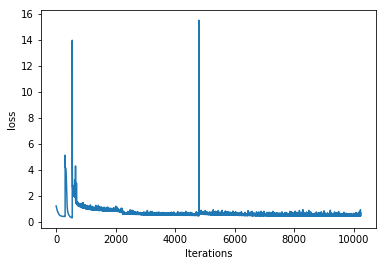

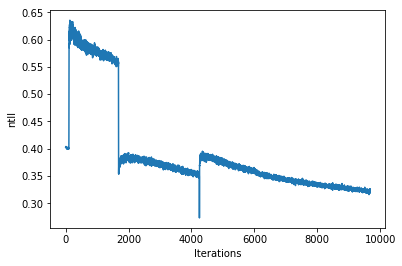

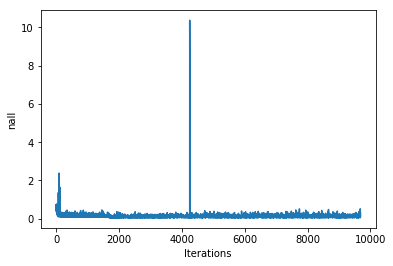

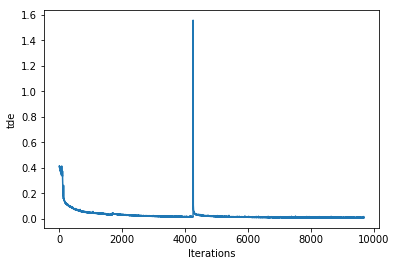

[('ntll', 0.32090646), ('tde', 0.011134315), ('nall', 0.18187238), ('loss', 0.5473161)]
[('ntll', 0.32179463), ('tde', 0.008704748), ('nall', 0.07485554), ('loss', 0.43146914)]
[('ntll', 0.3228847), ('tde', 0.008873869), ('nall', 0.081779234), ('loss', 0.44015944)]
[('ntll', 0.3208217), ('tde', 0.009078006), ('nall', 0.10355838), ('loss', 0.46069208)]
[('ntll', 0.31790292), ('tde', 0.010074768), ('nall', 0.12364316), ('loss', 0.48184514)]
[('ntll', 0.3211066), ('tde', 0.009926013), ('nall', 0.09437104), ('loss', 0.45518172)]
[('ntll', 0.31903824), ('tde', 0.015894718), ('nall', 0.31523392), ('loss', 0.69785106)]
[('ntll', 0.3188607), ('tde', 0.009177216), ('nall', 0.10233655), ('loss', 0.45790613)]
[('ntll', 0.31922075), ('tde', 0.009539077), ('nall', 0.11161164), ('loss', 0.4689887)]
[('ntll', 0.31578702), ('tde', 0.009342665), ('nall', 0.068775654), ('loss', 0.42193332)]


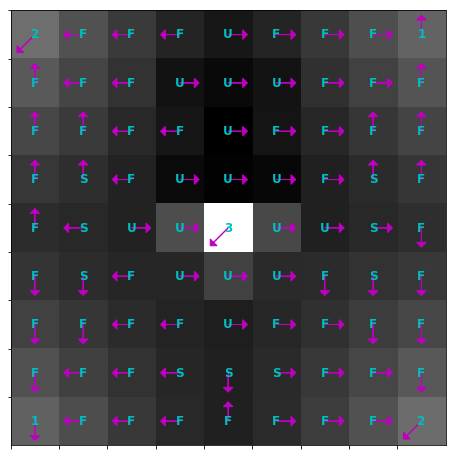

[[0.5484139  0.16606732 0.12511955 0.1603936  0.0000057 ]
 [0.13357325 0.6551707  0.20662124 0.00463484 0.        ]
 [0.09068372 0.22453855 0.53527915 0.14949833 0.00000023]
 [0.19772077 0.00073951 0.16217707 0.6375923  0.00177037]
 [0.00007372 0.         0.00006396 0.13073002 0.86913234]
 [0.00000968 0.00000026 0.00000994 0.00000241 0.9999777 ]
 [0.04316436 0.00751967 0.05628296 0.03597233 0.8570607 ]
 [0.07606386 0.01410291 0.07419959 0.04989554 0.78573817]
 [0.00431591 0.00034311 0.0024309  0.0222162  0.9706938 ]
 [0.00000018 0.         0.00000004 0.00003295 0.99996686]]


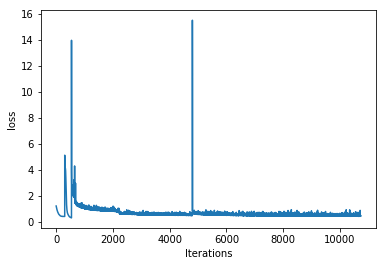

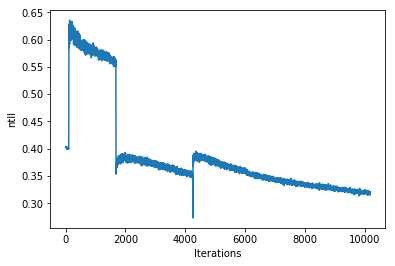

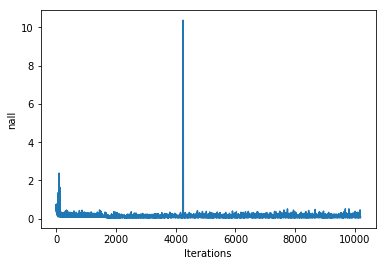

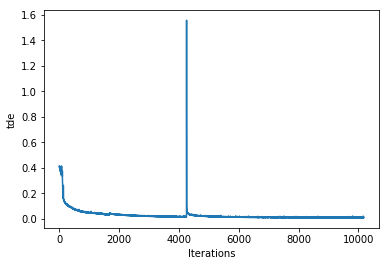

[('ntll', 0.32077518), ('tde', 0.009225333), ('nall', 0.107894406), ('loss', 0.4655709)]
[('ntll', 0.3201986), ('tde', 0.009807811), ('nall', 0.086542785), ('loss', 0.44597262)]
[('ntll', 0.318472), ('tde', 0.010582479), ('nall', 0.21531853), ('loss', 0.57612044)]
[('ntll', 0.313478), ('tde', 0.0128946835), ('nall', 0.19985329), ('loss', 0.56491005)]
[('ntll', 0.3193766), ('tde', 0.008076322), ('nall', 0.071388066), ('loss', 0.42306995)]
[('ntll', 0.31604928), ('tde', 0.009719749), ('nall', 0.09640967), ('loss', 0.45133796)]
[('ntll', 0.3185566), ('tde', 0.008720225), ('nall', 0.10083345), ('loss', 0.45427096)]
[('ntll', 0.3172878), ('tde', 0.008988489), ('nall', 0.15685079), ('loss', 0.51009256)]
[('ntll', 0.31540003), ('tde', 0.00888638), ('nall', 0.1515697), ('loss', 0.50251526)]
[('ntll', 0.31560108), ('tde', 0.009084438), ('nall', 0.09828854), ('loss', 0.45022738)]


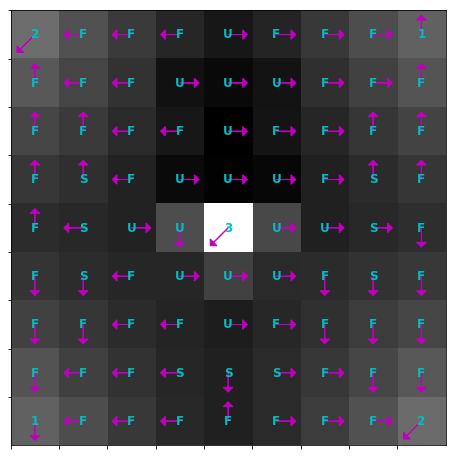

[[0.55064976 0.16477817 0.12352365 0.16104276 0.00000565]
 [0.13670872 0.6530211  0.20573162 0.00453852 0.        ]
 [0.09189365 0.21843418 0.5365991  0.15307285 0.00000023]
 [0.19404778 0.00062161 0.16016307 0.6434424  0.00172519]
 [0.00006825 0.         0.00006104 0.13138506 0.8684856 ]
 [0.00000928 0.00000025 0.00000934 0.00000245 0.99997866]
 [0.04265665 0.00760528 0.05504815 0.03615852 0.85853136]
 [0.07695955 0.01447973 0.07576904 0.05244641 0.78034526]
 [0.005234   0.00035261 0.00292476 0.02215693 0.9693317 ]
 [0.00000021 0.         0.00000005 0.00003292 0.99996686]]


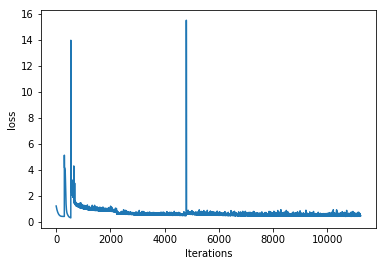

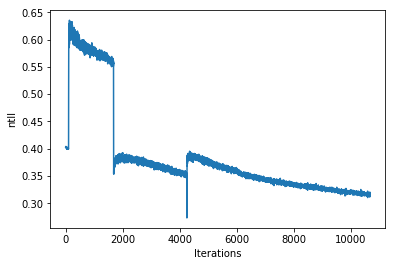

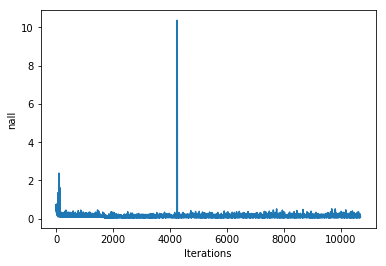

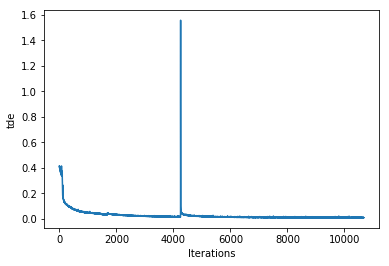

[('ntll', 0.3163825), ('tde', 0.009852447), ('nall', 0.077053934), ('loss', 0.43284622)]
[('ntll', 0.31920296), ('tde', 0.008480429), ('nall', 0.10667483), ('loss', 0.4597995)]
[('ntll', 0.31967756), ('tde', 0.007564503), ('nall', 0.07624388), ('loss', 0.42617944)]
[('ntll', 0.31435332), ('tde', 0.008325754), ('nall', 0.068375126), ('loss', 0.41603148)]
[('ntll', 0.31403637), ('tde', 0.009075313), ('nall', 0.12807594), ('loss', 0.47841358)]
[('ntll', 0.31445593), ('tde', 0.012658934), ('nall', 0.1811996), ('loss', 0.5462913)]
[('ntll', 0.31221783), ('tde', 0.010977359), ('nall', 0.11941739), ('loss', 0.47554466)]
[('ntll', 0.31446958), ('tde', 0.008703528), ('nall', 0.09624991), ('loss', 0.4455336)]
[('ntll', 0.31307536), ('tde', 0.010550766), ('nall', 0.144673), ('loss', 0.49995142)]
[('ntll', 0.31470278), ('tde', 0.008935902), ('nall', 0.1281637), ('loss', 0.4786101)]


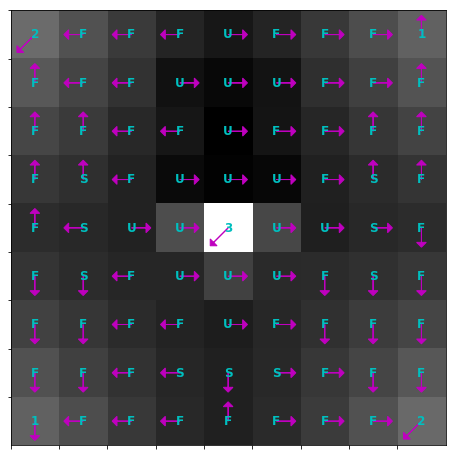

[[0.5524205  0.1642626  0.12098235 0.16232906 0.0000055 ]
 [0.13855912 0.6491265  0.20791203 0.00440223 0.        ]
 [0.09077094 0.21763067 0.54034793 0.15125026 0.00000021]
 [0.19587174 0.00054199 0.16118154 0.640733   0.00167177]
 [0.00006736 0.         0.00005934 0.12985934 0.870014  ]
 [0.00000905 0.00000025 0.00000874 0.00000253 0.9999794 ]
 [0.04216568 0.00766784 0.05475113 0.03587552 0.85953987]
 [0.07629213 0.01420217 0.0763792  0.05229773 0.78082883]
 [0.0064961  0.00036744 0.00367649 0.02197076 0.9674892 ]
 [0.00000025 0.         0.00000006 0.00003234 0.99996734]]


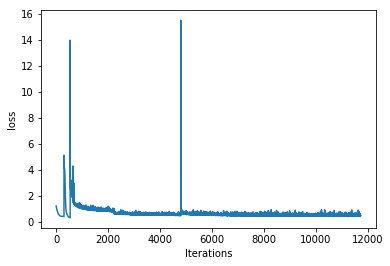

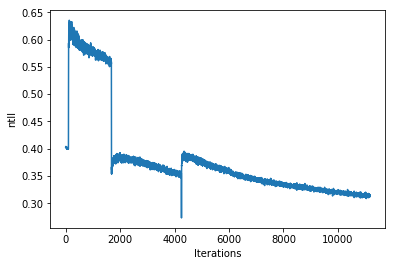

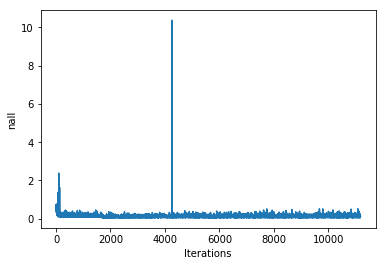

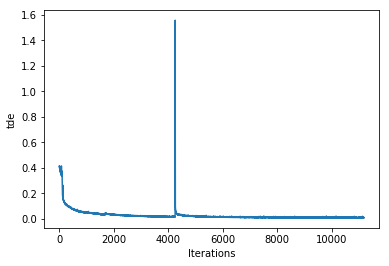

[('ntll', 0.31278682), ('tde', 0.009346099), ('nall', 0.19621481), ('loss', 0.546386)]
[('ntll', 0.31315824), ('tde', 0.010728247), ('nall', 0.26945698), ('loss', 0.6255282)]
[('ntll', 0.31597096), ('tde', 0.0076059075), ('nall', 0.07840177), ('loss', 0.42479637)]
[('ntll', 0.3131809), ('tde', 0.010779082), ('nall', 0.18714447), ('loss', 0.5434417)]
[('ntll', 0.3135568), ('tde', 0.008089239), ('nall', 0.09381975), ('loss', 0.43973348)]
[('ntll', 0.31308684), ('tde', 0.012477912), ('nall', 0.21737516), ('loss', 0.58037364)]
[('ntll', 0.31168148), ('tde', 0.00822187), ('nall', 0.089722246), ('loss', 0.4342912)]
[('ntll', 0.310437), ('tde', 0.009682214), ('nall', 0.26948848), ('loss', 0.6186543)]
[('ntll', 0.31134635), ('tde', 0.0086126765), ('nall', 0.13989145), ('loss', 0.4856885)]
[('ntll', 0.31088015), ('tde', 0.008437658), ('nall', 0.19322887), ('loss', 0.5378597)]


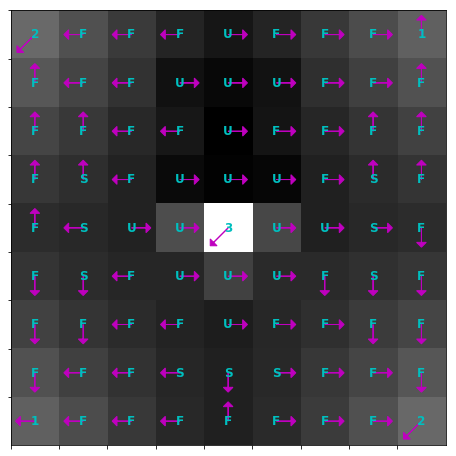

[[0.5566031  0.16605905 0.11626479 0.16106777 0.00000526]
 [0.13549861 0.65859264 0.20170623 0.00420254 0.        ]
 [0.08972595 0.22455625 0.5323108  0.15340678 0.00000021]
 [0.1929645  0.000509   0.15751942 0.6473507  0.00165641]
 [0.00006447 0.         0.00005557 0.12722139 0.8726585 ]
 [0.00000924 0.00000025 0.00000824 0.00000265 0.9999796 ]
 [0.0430756  0.00827841 0.05491459 0.03673157 0.8569998 ]
 [0.07738861 0.01593002 0.07765442 0.05419026 0.77483666]
 [0.00775409 0.00044412 0.00452218 0.02216206 0.9651176 ]
 [0.00000029 0.         0.00000007 0.00003191 0.9999677 ]]


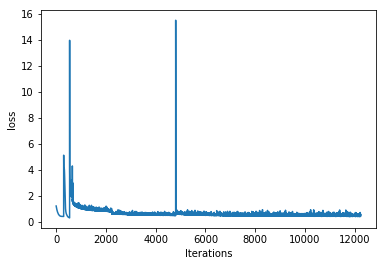

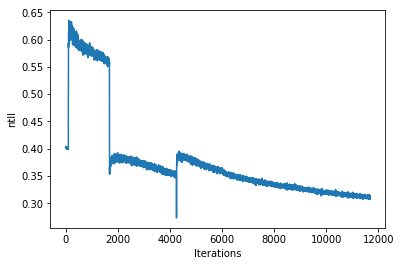

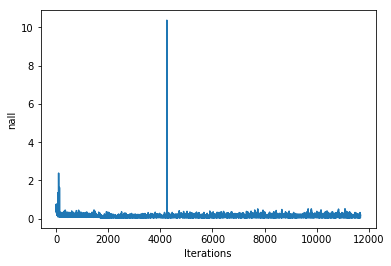

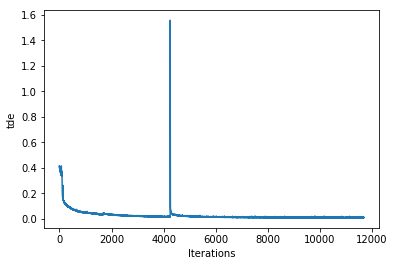

[('ntll', 0.30884716), ('tde', 0.008651894), ('nall', 0.10010891), ('loss', 0.44356364)]
[('ntll', 0.30940285), ('tde', 0.008630254), ('nall', 0.10025967), ('loss', 0.44418353)]
[('ntll', 0.3118677), ('tde', 0.011049458), ('nall', 0.31504717), ('loss', 0.6711127)]
[('ntll', 0.30890846), ('tde', 0.008850885), ('nall', 0.105250485), ('loss', 0.4495625)]
[('ntll', 0.30884588), ('tde', 0.00826519), ('nall', 0.06996823), ('loss', 0.41187486)]
[('ntll', 0.31029484), ('tde', 0.013452219), ('nall', 0.14243412), ('loss', 0.50653785)]
[('ntll', 0.30958083), ('tde', 0.00856374), ('nall', 0.119604155), ('loss', 0.46343994)]
[('ntll', 0.308216), ('tde', 0.008228932), ('nall', 0.08463242), ('loss', 0.42576414)]
[('ntll', 0.30882776), ('tde', 0.0104904855), ('nall', 0.2521444), ('loss', 0.6029341)]
[('ntll', 0.30852252), ('tde', 0.007997363), ('nall', 0.08585875), ('loss', 0.42637074)]


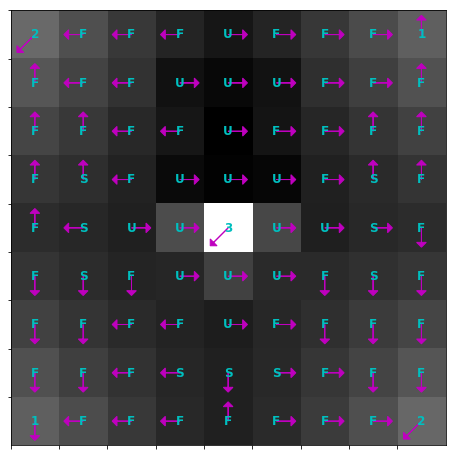

[[0.5589251  0.16463113 0.113528   0.16291058 0.00000517]
 [0.13365515 0.66161853 0.20069142 0.00403491 0.        ]
 [0.08881398 0.22005731 0.53942317 0.15170538 0.0000002 ]
 [0.19437474 0.00044578 0.16194293 0.6416232  0.00161337]
 [0.00006135 0.         0.00005487 0.12506805 0.8748157 ]
 [0.00000884 0.00000022 0.00000735 0.00000263 0.9999809 ]
 [0.04144257 0.00779776 0.05217167 0.03490719 0.86368084]
 [0.07400813 0.01488797 0.07517587 0.0523838  0.78354424]
 [0.0082971  0.00046636 0.00529614 0.02078879 0.96515155]
 [0.0000003  0.         0.00000008 0.00002997 0.9999696 ]]


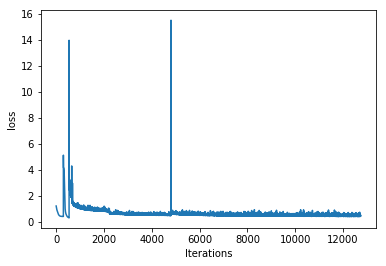

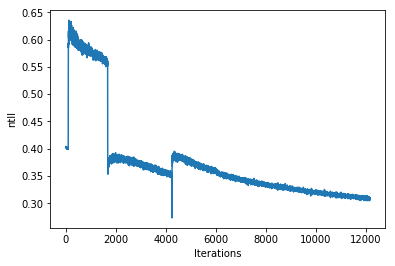

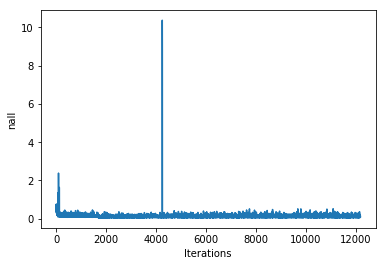

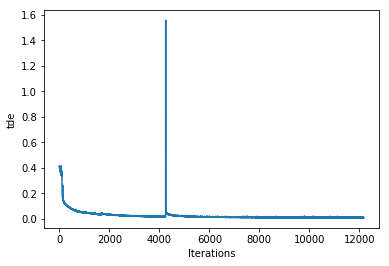

[('ntll', 0.30578932), ('tde', 0.0096152555), ('nall', 0.09506408), ('loss', 0.43931442)]
[('ntll', 0.3073694), ('tde', 0.009953245), ('nall', 0.23990585), ('loss', 0.5870882)]
[('ntll', 0.3055229), ('tde', 0.012203265), ('nall', 0.20654522), ('loss', 0.56088114)]
[('ntll', 0.30759943), ('tde', 0.0075284317), ('nall', 0.070398), ('loss', 0.40811116)]
[('ntll', 0.30478922), ('tde', 0.008369506), ('nall', 0.07232413), ('loss', 0.41059136)]
[('ntll', 0.30832723), ('tde', 0.009122331), ('nall', 0.12960379), ('loss', 0.4744203)]
[('ntll', 0.30442148), ('tde', 0.011820963), ('nall', 0.20145315), ('loss', 0.55315846)]
[('ntll', 0.30618426), ('tde', 0.011360776), ('nall', 0.16290593), ('loss', 0.5145333)]
[('ntll', 0.30566853), ('tde', 0.008219792), ('nall', 0.08416664), ('loss', 0.42271435)]
[('ntll', 0.30689612), ('tde', 0.007534137), ('nall', 0.0710348), ('loss', 0.40806746)]


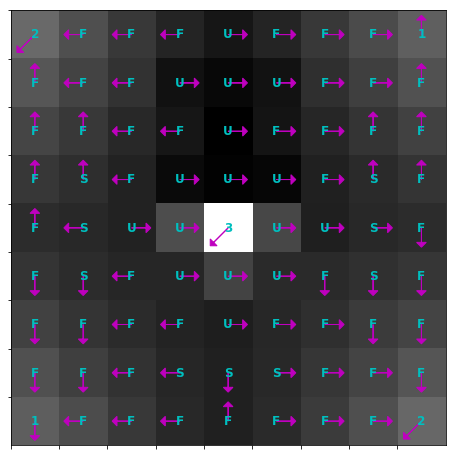

[[0.55868506 0.16712664 0.11154011 0.1626432  0.00000502]
 [0.1363306  0.6571286  0.20262972 0.00391116 0.        ]
 [0.09050471 0.21443783 0.5406652  0.15439206 0.00000019]
 [0.19353342 0.00038664 0.15997781 0.6445073  0.00159489]
 [0.00005758 0.         0.00005188 0.12262115 0.8772694 ]
 [0.00000886 0.00000023 0.00000692 0.00000279 0.99998116]
 [0.04227839 0.00795718 0.05219074 0.03554971 0.862024  ]
 [0.07466611 0.01504744 0.07667472 0.05366392 0.7799478 ]
 [0.00902171 0.000525   0.00625828 0.02098952 0.9632055 ]
 [0.00000032 0.         0.00000009 0.00002989 0.9999697 ]]


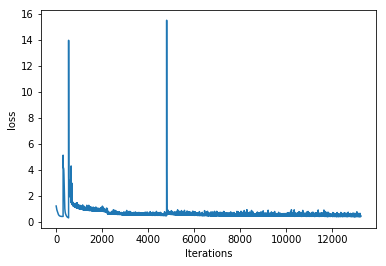

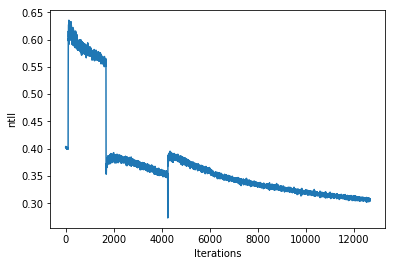

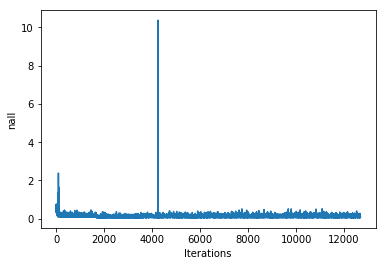

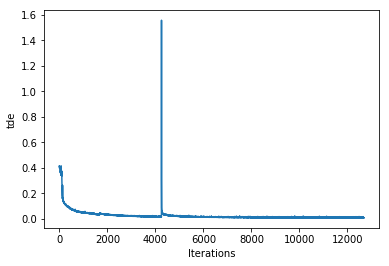

[('ntll', 0.30403718), ('tde', 0.009047739), ('nall', 0.10609879), ('loss', 0.44632694)]
[('ntll', 0.30801076), ('tde', 0.009594601), ('nall', 0.20790206), ('loss', 0.55429125)]
[('ntll', 0.30726317), ('tde', 0.0070205857), ('nall', 0.09712522), ('loss', 0.4324707)]
[('ntll', 0.30480558), ('tde', 0.008608929), ('nall', 0.06976572), ('loss', 0.409007)]
[('ntll', 0.30664128), ('tde', 0.008322349), ('nall', 0.0860185), ('loss', 0.4259492)]
[('ntll', 0.30409905), ('tde', 0.008076482), ('nall', 0.07013249), ('loss', 0.40653747)]
[('ntll', 0.3069265), ('tde', 0.012115521), ('nall', 0.23914531), ('loss', 0.59453386)]
[('ntll', 0.30502677), ('tde', 0.008320499), ('nall', 0.17832391), ('loss', 0.5166327)]
[('ntll', 0.3053117), ('tde', 0.00880219), ('nall', 0.06721855), ('loss', 0.407739)]
[('ntll', 0.3042373), ('tde', 0.0079842135), ('nall', 0.0695902), ('loss', 0.40576437)]


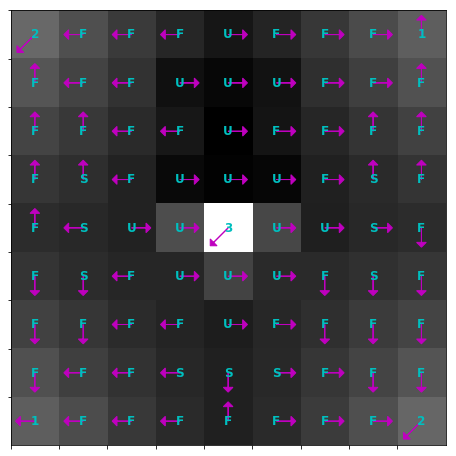

[[0.5618575  0.16614322 0.11138632 0.16060807 0.00000489]
 [0.13542958 0.65963966 0.20118411 0.00374667 0.        ]
 [0.0900749  0.21485527 0.54074025 0.15432939 0.00000019]
 [0.19535184 0.00035169 0.15763333 0.64509076 0.00157241]
 [0.00005558 0.         0.00004828 0.12002582 0.8798703 ]
 [0.00000872 0.00000021 0.00000654 0.00000289 0.99998164]
 [0.04188007 0.00765881 0.05148141 0.0350374  0.86394227]
 [0.07305723 0.01504637 0.07550355 0.05323119 0.7831617 ]
 [0.00888402 0.00054738 0.00646353 0.01995969 0.9641453 ]
 [0.00000031 0.         0.00000009 0.0000282  0.9999714 ]]


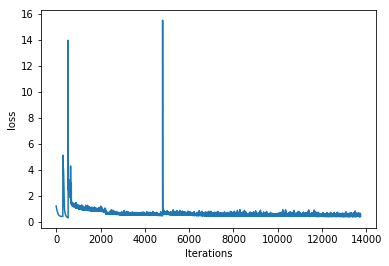

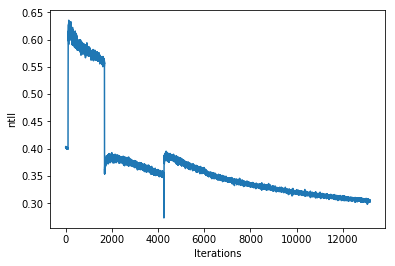

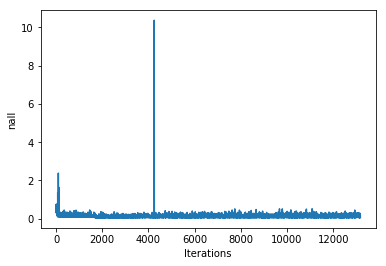

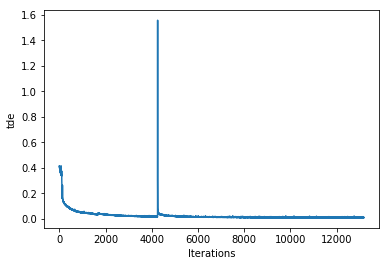

[('ntll', 0.30761713), ('tde', 0.010746373), ('nall', 0.15761809), ('loss', 0.50822073)]
[('ntll', 0.30334523), ('tde', 0.009171625), ('nall', 0.092640676), ('loss', 0.4326724)]
[('ntll', 0.3031135), ('tde', 0.007819465), ('nall', 0.078010246), ('loss', 0.4124016)]
[('ntll', 0.304063), ('tde', 0.007618982), ('nall', 0.119579405), ('loss', 0.4541183)]
[('ntll', 0.30323339), ('tde', 0.008099171), ('nall', 0.08781637), ('loss', 0.42344642)]
[('ntll', 0.30526036), ('tde', 0.011113518), ('nall', 0.19502448), ('loss', 0.54473895)]
[('ntll', 0.29871216), ('tde', 0.011716904), ('nall', 0.26559573), ('loss', 0.61117554)]
[('ntll', 0.30134845), ('tde', 0.010256073), ('nall', 0.152256), ('loss', 0.49462876)]
[('ntll', 0.29951876), ('tde', 0.009071596), ('nall', 0.12586856), ('loss', 0.4616737)]
[('ntll', 0.30454823), ('tde', 0.007749458), ('nall', 0.14641462), ('loss', 0.48196068)]


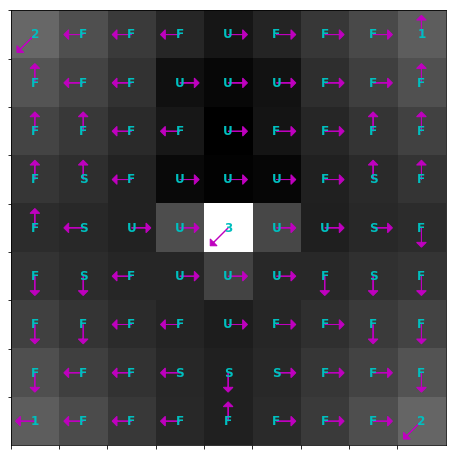

[[0.56309706 0.16907825 0.1075964  0.16022353 0.00000477]
 [0.13658282 0.65908116 0.20068441 0.00365157 0.        ]
 [0.08833634 0.21048479 0.5459081  0.15527056 0.00000017]
 [0.19021742 0.00031387 0.15839684 0.6495648  0.00150712]
 [0.00005339 0.         0.00004825 0.12161335 0.878285  ]
 [0.00000852 0.0000002  0.00000584 0.00000301 0.9999825 ]
 [0.04216418 0.00768667 0.05086055 0.03519252 0.86409605]
 [0.07378922 0.01541964 0.07657082 0.05445791 0.77976245]
 [0.00945516 0.00060451 0.00742224 0.02075633 0.9617617 ]
 [0.00000031 0.         0.0000001  0.0000286  0.99997103]]


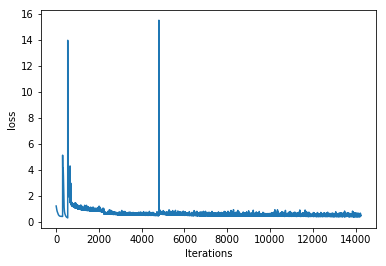

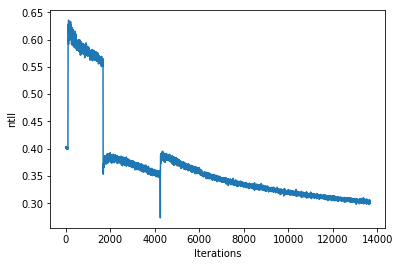

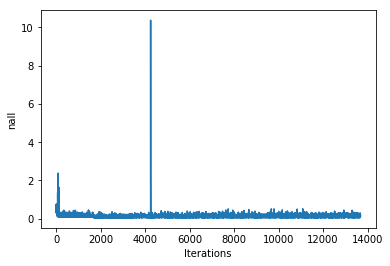

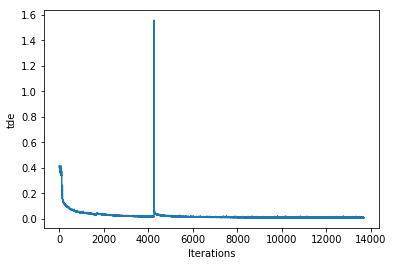

[('ntll', 0.3060915), ('tde', 0.0072086286), ('nall', 0.10468795), ('loss', 0.43961397)]
[('ntll', 0.30027658), ('tde', 0.010823469), ('nall', 0.10931875), ('loss', 0.45288917)]
[('ntll', 0.30185002), ('tde', 0.0076320306), ('nall', 0.090919316), ('loss', 0.42329746)]
[('ntll', 0.30096728), ('tde', 0.008823722), ('nall', 0.16130382), ('loss', 0.49756598)]
[('ntll', 0.30247563), ('tde', 0.0071501574), ('nall', 0.10771214), ('loss', 0.4387884)]
[('ntll', 0.3014239), ('tde', 0.008488384), ('nall', 0.15836963), ('loss', 0.4937471)]
[('ntll', 0.3025167), ('tde', 0.006945704), ('nall', 0.13378681), ('loss', 0.46408632)]
[('ntll', 0.30238846), ('tde', 0.007247669), ('nall', 0.051645305), ('loss', 0.38302445)]
[('ntll', 0.3002215), ('tde', 0.0073752287), ('nall', 0.08233502), ('loss', 0.41205743)]
[('ntll', 0.3014917), ('tde', 0.010920023), ('nall', 0.10930525), ('loss', 0.45447704)]


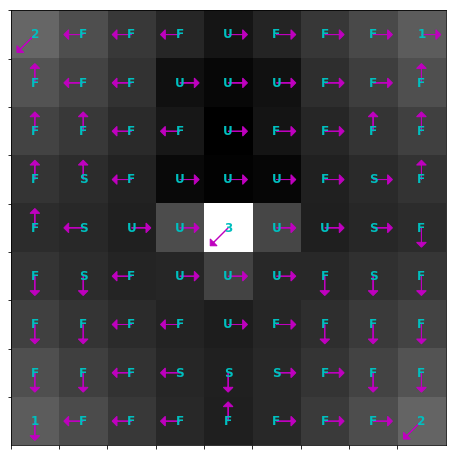

[[0.5637572  0.16784655 0.10276821 0.16562325 0.00000474]
 [0.13624719 0.6614204  0.19871663 0.00361578 0.        ]
 [0.08821067 0.21159062 0.5422079  0.15799063 0.00000017]
 [0.18880273 0.00028479 0.15572497 0.6536949  0.00149262]
 [0.00005108 0.         0.00004579 0.11857063 0.88133246]
 [0.00000811 0.00000018 0.00000504 0.00000316 0.99998355]
 [0.0415075  0.00736042 0.04868347 0.03460953 0.8678391 ]
 [0.07232653 0.01516539 0.07397478 0.05365492 0.7848784 ]
 [0.00965568 0.00063733 0.00795886 0.01999366 0.96175444]
 [0.00000031 0.         0.0000001  0.00002703 0.9999726 ]]


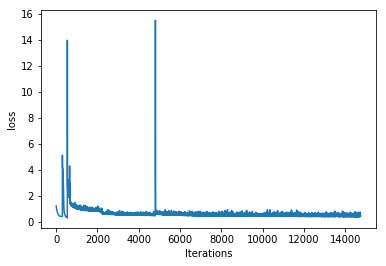

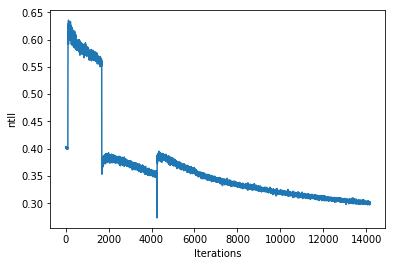

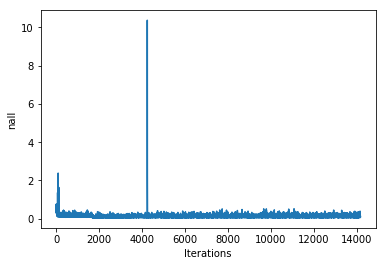

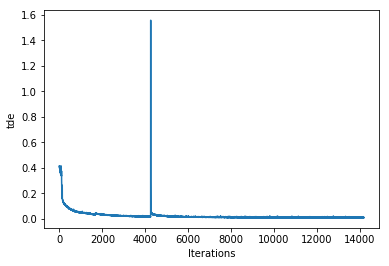

[('ntll', 0.30166158), ('tde', 0.009726245), ('nall', 0.18804453), ('loss', 0.52861106)]
[('ntll', 0.29889905), ('tde', 0.008782576), ('nall', 0.15526444), ('loss', 0.48929378)]
[('ntll', 0.30137944), ('tde', 0.006716109), ('nall', 0.05891102), ('loss', 0.3871549)]
[('ntll', 0.29842865), ('tde', 0.0077509745), ('nall', 0.093642), ('loss', 0.42307454)]
[('ntll', 0.29772535), ('tde', 0.008758166), ('nall', 0.109948784), ('loss', 0.4427068)]
[('ntll', 0.29728127), ('tde', 0.007655121), ('nall', 0.06766183), ('loss', 0.39556357)]
[('ntll', 0.3017112), ('tde', 0.0070238733), ('nall', 0.09156511), ('loss', 0.4213718)]
[('ntll', 0.29798993), ('tde', 0.008272659), ('nall', 0.09024203), ('loss', 0.42132258)]
[('ntll', 0.3000309), ('tde', 0.0076120426), ('nall', 0.08724708), ('loss', 0.41772613)]
[('ntll', 0.29811192), ('tde', 0.009019325), ('nall', 0.1587229), ('loss', 0.4929121)]


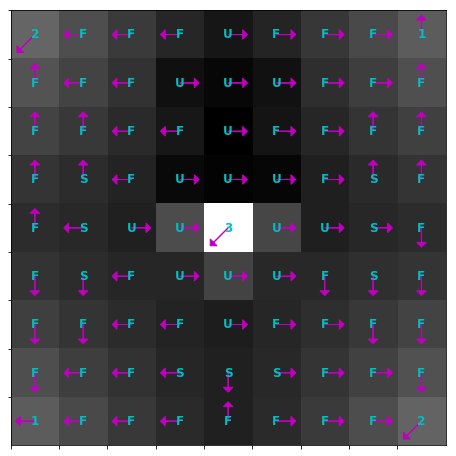

[[0.5683373  0.1697215  0.1006551  0.1612816  0.00000454]
 [0.13440217 0.66386163 0.19833286 0.00340335 0.        ]
 [0.08633729 0.2137691  0.5479851  0.15190843 0.00000015]
 [0.19178282 0.00026739 0.16132973 0.64516634 0.00145375]
 [0.00005128 0.         0.00004656 0.11435683 0.8855453 ]
 [0.00000816 0.00000018 0.00000464 0.00000338 0.99998367]
 [0.04316221 0.00787172 0.05052607 0.03556447 0.86287546]
 [0.07434862 0.01610928 0.07704104 0.05496376 0.77753735]
 [0.01046203 0.00070715 0.00934031 0.0197664  0.9597241 ]
 [0.00000033 0.         0.00000011 0.00002596 0.99997365]]


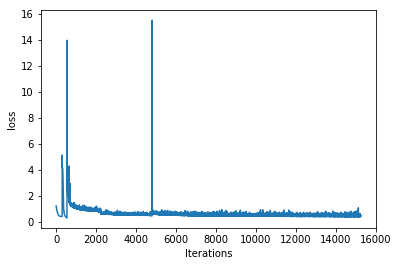

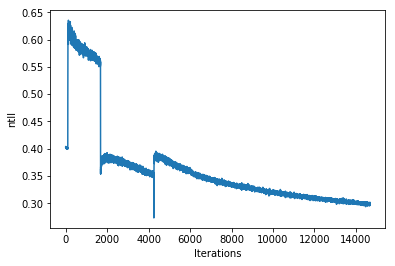

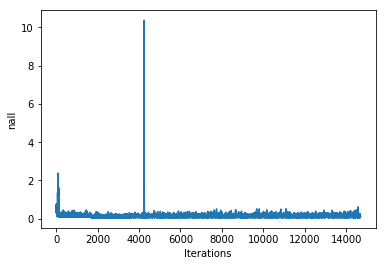

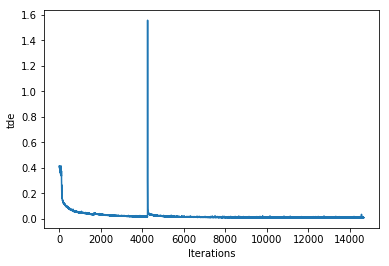

[('ntll', 0.29475796), ('tde', 0.018199204), ('nall', 0.32625064), ('loss', 0.69380546)]
[('ntll', 0.29500806), ('tde', 0.008617954), ('nall', 0.08467742), ('loss', 0.4141573)]
[('ntll', 0.29766238), ('tde', 0.0085854), ('nall', 0.1085267), ('loss', 0.4405307)]
[('ntll', 0.29902908), ('tde', 0.0070522595), ('nall', 0.10453494), ('loss', 0.43177307)]
[('ntll', 0.2977821), ('tde', 0.009308057), ('nall', 0.115679905), ('loss', 0.4506942)]
[('ntll', 0.2953478), ('tde', 0.010330231), ('nall', 0.18470982), ('loss', 0.5213786)]
[('ntll', 0.3015655), ('tde', 0.006775778), ('nall', 0.085291706), ('loss', 0.41396034)]
[('ntll', 0.2978445), ('tde', 0.0071211974), ('nall', 0.11664747), ('loss', 0.44297674)]
[('ntll', 0.29700926), ('tde', 0.007006616), ('nall', 0.08000387), ('loss', 0.4050396)]
[('ntll', 0.29703775), ('tde', 0.0075119007), ('nall', 0.1696046), ('loss', 0.49668995)]


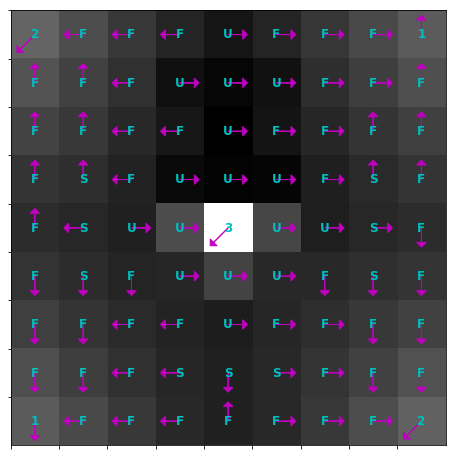

[[0.57106227 0.16845213 0.09787533 0.1626058  0.00000449]
 [0.13723248 0.660946   0.19846334 0.00335816 0.        ]
 [0.08809877 0.20572254 0.54956686 0.15661168 0.00000015]
 [0.18993649 0.00022063 0.1550951  0.6533264  0.00142135]
 [0.00004885 0.         0.00004306 0.11411855 0.8857896 ]
 [0.00000775 0.00000017 0.00000413 0.00000358 0.9999844 ]
 [0.04313549 0.00795151 0.05035358 0.0357754  0.86278397]
 [0.0738554  0.01593068 0.07572259 0.05526035 0.77923095]
 [0.01125357 0.00074196 0.01045893 0.01970287 0.95784265]
 [0.00000034 0.         0.00000012 0.00002591 0.99997365]]


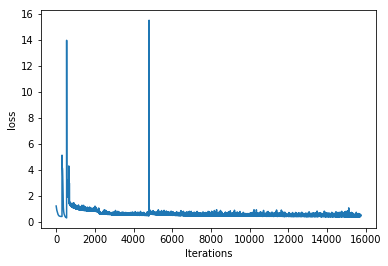

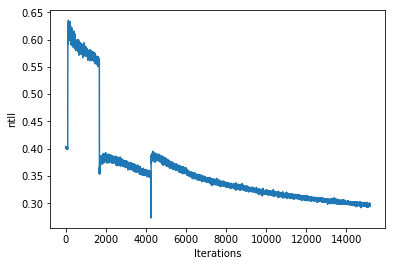

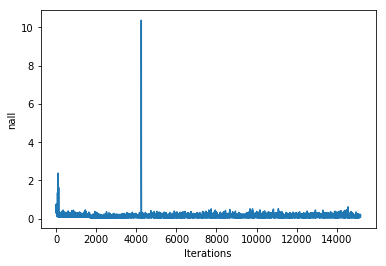

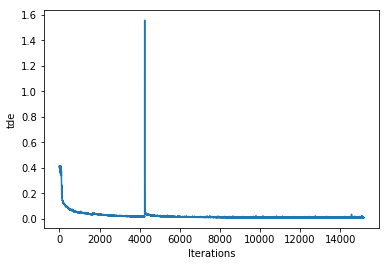

[('ntll', 0.29612568), ('tde', 0.008454958), ('nall', 0.11423981), ('loss', 0.44418532)]
[('ntll', 0.29252407), ('tde', 0.0116952695), ('nall', 0.28778443), ('loss', 0.62708956)]
[('ntll', 0.2959456), ('tde', 0.007385582), ('nall', 0.092732936), ('loss', 0.41822088)]
[('ntll', 0.29743114), ('tde', 0.010360307), ('nall', 0.12960829), ('loss', 0.46848068)]
[('ntll', 0.2940698), ('tde', 0.007636162), ('nall', 0.11702549), ('loss', 0.44163993)]
[('ntll', 0.29591602), ('tde', 0.0068677478), ('nall', 0.06592922), ('loss', 0.38931626)]
[('ntll', 0.2960156), ('tde', 0.0076248036), ('nall', 0.08859717), ('loss', 0.415112)]
[('ntll', 0.2957028), ('tde', 0.007321091), ('nall', 0.07423675), ('loss', 0.3992239)]
[('ntll', 0.2949062), ('tde', 0.008225685), ('nall', 0.07670966), ('loss', 0.4045186)]
[('ntll', 0.2950614), ('tde', 0.009062701), ('nall', 0.10890697), ('loss', 0.4402192)]


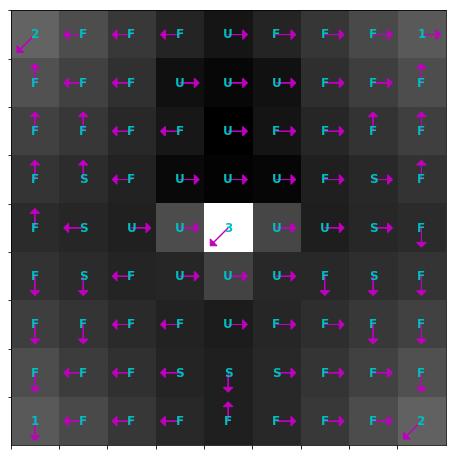

[[0.5720136  0.16832168 0.09369706 0.16596308 0.00000451]
 [0.135488   0.66259027 0.19861723 0.00330453 0.        ]
 [0.0845001  0.19884975 0.55853635 0.15811369 0.00000014]
 [0.18083517 0.00019652 0.16164032 0.65594566 0.00138228]
 [0.00004372 0.         0.00004436 0.11314483 0.8867671 ]
 [0.00000704 0.00000015 0.00000341 0.00000358 0.9999858 ]
 [0.04101663 0.00746636 0.04834075 0.03482648 0.8683498 ]
 [0.06926031 0.01492869 0.07420919 0.05416923 0.7874326 ]
 [0.01124119 0.00075554 0.01213058 0.0192832  0.9565895 ]
 [0.00000033 0.         0.00000014 0.00002532 0.99997425]]


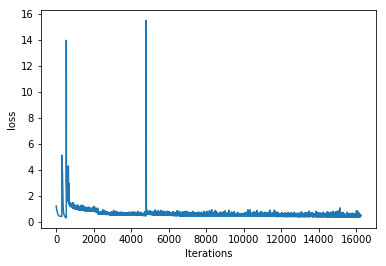

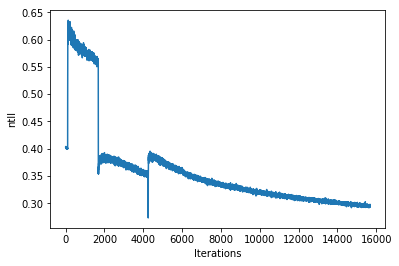

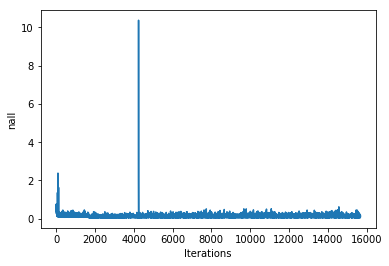

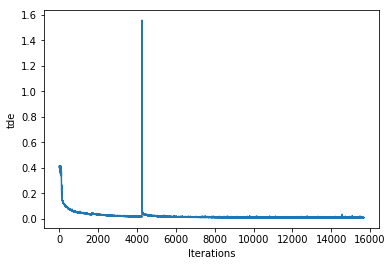

[('ntll', 0.29499564), ('tde', 0.007965606), ('nall', 0.12069772), ('loss', 0.44755578)]
[('ntll', 0.29423785), ('tde', 0.007254181), ('nall', 0.07373272), ('loss', 0.39698732)]
[('ntll', 0.29474533), ('tde', 0.00800649), ('nall', 0.10804292), ('loss', 0.4348142)]
[('ntll', 0.2929569), ('tde', 0.0075615947), ('nall', 0.06373308), ('loss', 0.38693634)]
[('ntll', 0.29222456), ('tde', 0.008674261), ('nall', 0.18416078), ('loss', 0.5110824)]
[('ntll', 0.29379225), ('tde', 0.0088449605), ('nall', 0.22009784), ('loss', 0.5492699)]
[('ntll', 0.29299107), ('tde', 0.0071257404), ('nall', 0.09081806), ('loss', 0.41231212)]
[('ntll', 0.29211715), ('tde', 0.0073040337), ('nall', 0.12137952), ('loss', 0.4427128)]
[('ntll', 0.29252523), ('tde', 0.0088304235), ('nall', 0.11170615), ('loss', 0.43955305)]
[('ntll', 0.29385078), ('tde', 0.006684366), ('nall', 0.07231513), ('loss', 0.39290336)]


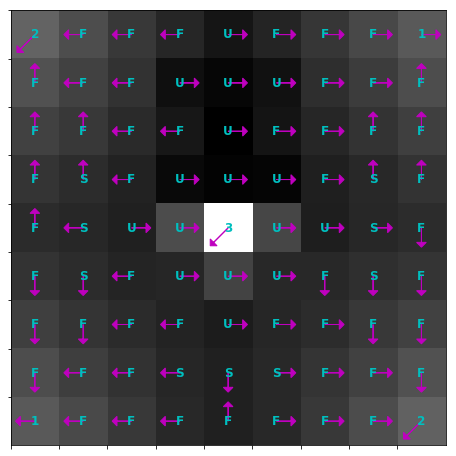

[[0.57423234 0.17159374 0.0883067  0.16586277 0.00000446]
 [0.1360109  0.66570395 0.19505325 0.00323192 0.        ]
 [0.08460951 0.20774694 0.550621   0.15702243 0.00000013]
 [0.19148536 0.00018727 0.15603282 0.6509596  0.00133494]
 [0.0000503  0.         0.00004321 0.11140364 0.8885029 ]
 [0.00000684 0.00000015 0.00000294 0.00000375 0.9999863 ]
 [0.04300687 0.00804145 0.04924489 0.0360124  0.86369437]
 [0.07317348 0.01616113 0.07479275 0.05512337 0.7807493 ]
 [0.0134604  0.00096646 0.01454733 0.02043167 0.9505941 ]
 [0.00000042 0.         0.00000016 0.00002565 0.9999738 ]]


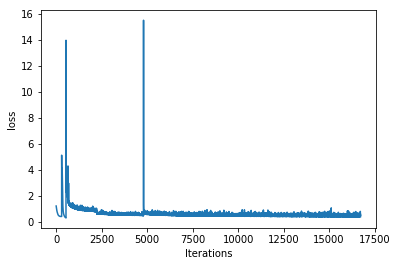

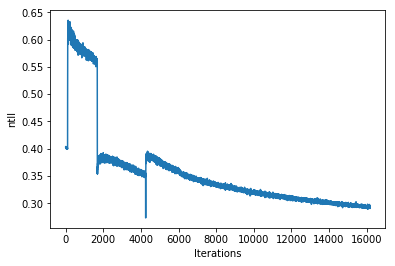

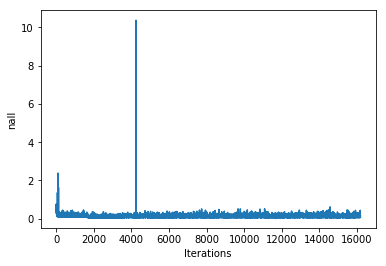

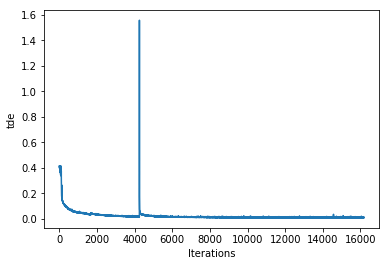

[('ntll', 0.29285836), ('tde', 0.011201358), ('nall', 0.2921362), ('loss', 0.62979996)]
[('ntll', 0.2921296), ('tde', 0.0077855275), ('nall', 0.15266103), ('loss', 0.47593275)]
[('ntll', 0.29318082), ('tde', 0.0068965787), ('nall', 0.12068197), ('loss', 0.4414491)]
[('ntll', 0.29199526), ('tde', 0.0075486717), ('nall', 0.08640778), ('loss', 0.40859774)]
[('ntll', 0.29408836), ('tde', 0.007295638), ('nall', 0.087548606), ('loss', 0.41081953)]
[('ntll', 0.29049385), ('tde', 0.0073377476), ('nall', 0.05655287), ('loss', 0.3763977)]
[('ntll', 0.2925543), ('tde', 0.00684295), ('nall', 0.08343084), ('loss', 0.40335694)]
[('ntll', 0.29269132), ('tde', 0.0073237405), ('nall', 0.05202783), ('loss', 0.3740141)]
[('ntll', 0.29187956), ('tde', 0.007100254), ('nall', 0.105489), ('loss', 0.42576957)]
[('ntll', 0.29142404), ('tde', 0.0073935157), ('nall', 0.14267713), ('loss', 0.46367523)]


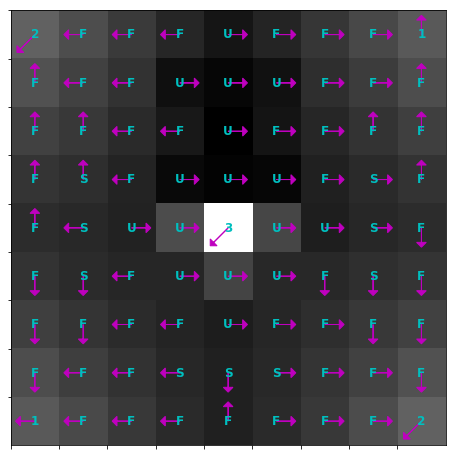

[[0.5760171  0.17037603 0.08735679 0.16624561 0.00000456]
 [0.1342668  0.6676007  0.19496833 0.00316419 0.        ]
 [0.08232735 0.2055334  0.5522332  0.15990587 0.00000013]
 [0.18555056 0.00016808 0.15318024 0.6597816  0.00131955]
 [0.00004504 0.         0.00003951 0.10996602 0.88994944]
 [0.00000624 0.00000013 0.00000252 0.00000366 0.9999875 ]
 [0.04188196 0.00761803 0.04783247 0.03515408 0.8675135 ]
 [0.07143416 0.01599775 0.07434581 0.05551748 0.7827048 ]
 [0.01408262 0.00107357 0.01640369 0.02065849 0.9477817 ]
 [0.0000004  0.         0.00000017 0.00002485 0.9999746 ]]


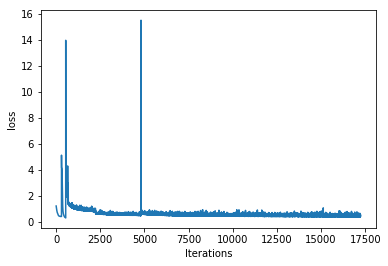

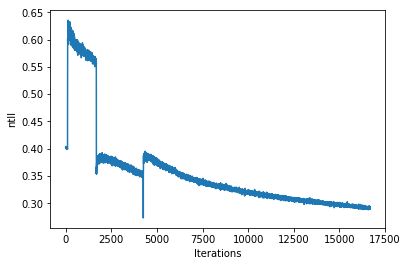

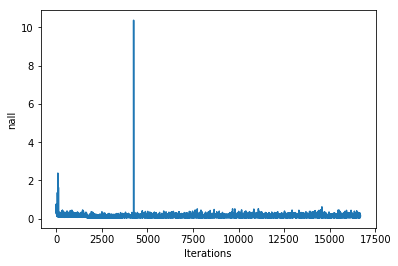

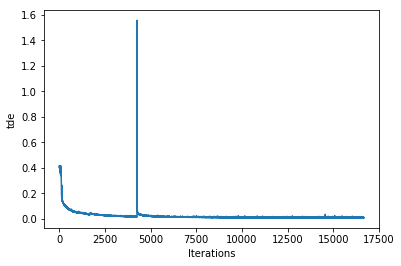

[('ntll', 0.28973973), ('tde', 0.008753584), ('nall', 0.2094434), ('loss', 0.53419745)]
[('ntll', 0.29212216), ('tde', 0.009461621), ('nall', 0.21540178), ('loss', 0.54537046)]
[('ntll', 0.28923178), ('tde', 0.0075423894), ('nall', 0.10816442), ('loss', 0.42756575)]
[('ntll', 0.29059672), ('tde', 0.007036385), ('nall', 0.07978111), ('loss', 0.3985234)]
[('ntll', 0.2907462), ('tde', 0.0088616), ('nall', 0.11419931), ('loss', 0.44039193)]
[('ntll', 0.2932573), ('tde', 0.0063774763), ('nall', 0.10905098), ('loss', 0.42781818)]
[('ntll', 0.29115915), ('tde', 0.0077041704), ('nall', 0.11645845), ('loss', 0.43843427)]
[('ntll', 0.2893392), ('tde', 0.0074315), ('nall', 0.13958544), ('loss', 0.45865065)]
[('ntll', 0.2920839), ('tde', 0.009639514), ('nall', 0.1303441), ('loss', 0.46098605)]
[('ntll', 0.29089135), ('tde', 0.008558304), ('nall', 0.16522582), ('loss', 0.49035037)]


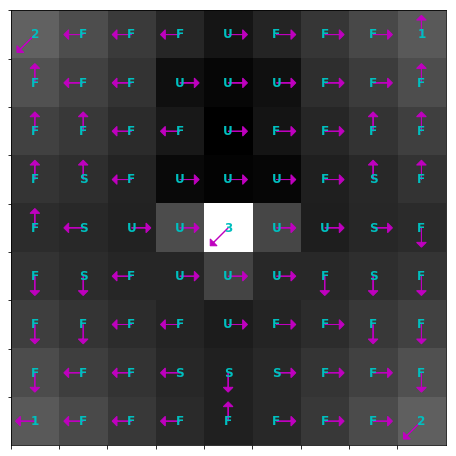

[[0.5758974  0.17124476 0.08334241 0.16951086 0.00000462]
 [0.13549253 0.6709261  0.19040407 0.00317728 0.        ]
 [0.07876317 0.20926721 0.55227435 0.1596952  0.00000012]
 [0.18400773 0.00016384 0.15672413 0.6578445  0.00125977]
 [0.00004503 0.         0.00004083 0.10995116 0.88996303]
 [0.00000589 0.00000012 0.00000224 0.00000375 0.99998796]
 [0.04165501 0.00785966 0.04762578 0.03577331 0.8670862 ]
 [0.06914501 0.01576734 0.07138103 0.05397861 0.78972805]
 [0.01439897 0.00119307 0.01759479 0.02023904 0.9465741 ]
 [0.0000004  0.         0.00000018 0.00002338 0.99997604]]


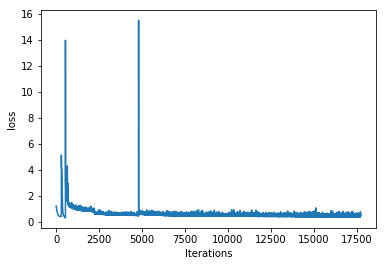

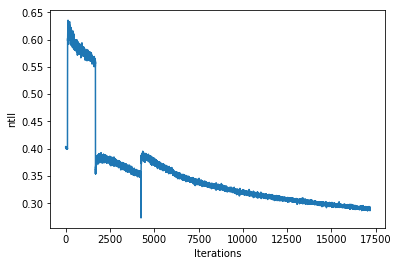

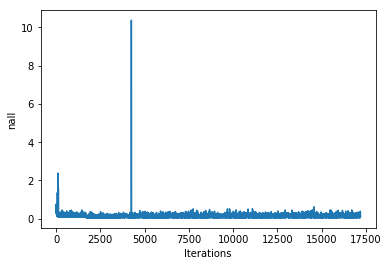

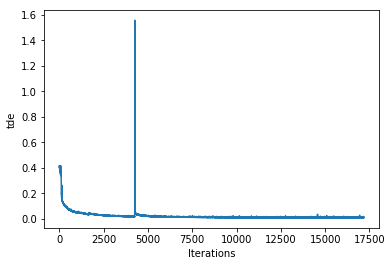

[('ntll', 0.28848165), ('tde', 0.009013977), ('nall', 0.11717175), ('loss', 0.44170934)]
[('ntll', 0.28915706), ('tde', 0.007125774), ('nall', 0.081450716), ('loss', 0.39911088)]
[('ntll', 0.29118216), ('tde', 0.008682878), ('nall', 0.17712234), ('loss', 0.503036)]
[('ntll', 0.2898875), ('tde', 0.0075812046), ('nall', 0.22230747), ('loss', 0.5425198)]
[('ntll', 0.29008546), ('tde', 0.006484132), ('nall', 0.08379311), ('loss', 0.39981508)]
[('ntll', 0.29135683), ('tde', 0.007963264), ('nall', 0.078188), ('loss', 0.40139788)]
[('ntll', 0.2881209), ('tde', 0.010229591), ('nall', 0.15831113), ('loss', 0.4873504)]
[('ntll', 0.28800458), ('tde', 0.006742954), ('nall', 0.06808936), ('loss', 0.38306576)]
[('ntll', 0.2884943), ('tde', 0.0068169325), ('nall', 0.100909956), ('loss', 0.41667196)]
[('ntll', 0.28920192), ('tde', 0.006027623), ('nall', 0.054316226), ('loss', 0.36762863)]


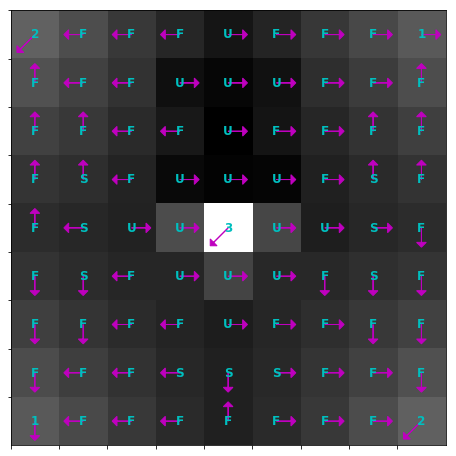

[[0.57753104 0.17193854 0.08404578 0.16647997 0.00000467]
 [0.13466685 0.6661335  0.19614905 0.00305057 0.        ]
 [0.07863032 0.2063719  0.55477875 0.16021892 0.00000011]
 [0.18821463 0.00015091 0.15246335 0.6579305  0.00124061]
 [0.00004813 0.         0.00003863 0.10715568 0.89275753]
 [0.00000569 0.00000011 0.00000203 0.0000036  0.99998856]
 [0.0419336  0.0075931  0.04660134 0.03514483 0.8687271 ]
 [0.07089934 0.01599286 0.07226072 0.05500885 0.78583825]
 [0.01604602 0.00136319 0.01950858 0.02097563 0.94210654]
 [0.00000045 0.         0.00000019 0.00002352 0.9999758 ]]


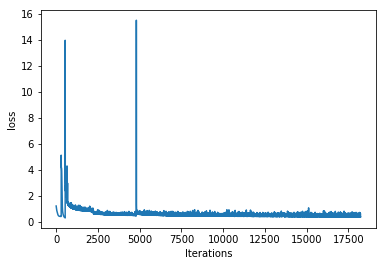

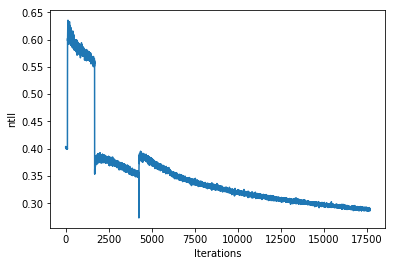

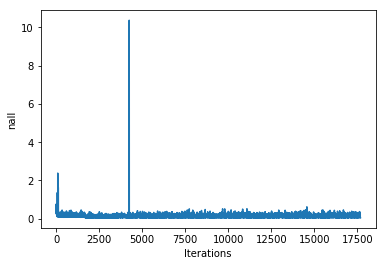

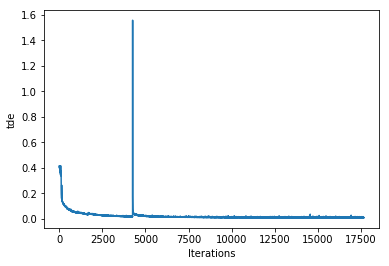

[('ntll', 0.2879782), ('tde', 0.008291384), ('nall', 0.14578684), ('loss', 0.4669306)]
[('ntll', 0.2857009), ('tde', 0.008293868), ('nall', 0.093050204), ('loss', 0.41192657)]
[('ntll', 0.28873292), ('tde', 0.006171209), ('nall', 0.05981558), ('loss', 0.37323335)]
[('ntll', 0.2876543), ('tde', 0.0068203816), ('nall', 0.084409654), ('loss', 0.3993455)]
[('ntll', 0.28725132), ('tde', 0.0071246284), ('nall', 0.09280494), ('loss', 0.40855476)]
[('ntll', 0.28693876), ('tde', 0.010460532), ('nall', 0.26163548), ('loss', 0.5904163)]
[('ntll', 0.28729424), ('tde', 0.006435634), ('nall', 0.08103894), ('loss', 0.3940757)]
[('ntll', 0.28705472), ('tde', 0.009584308), ('nall', 0.15800062), ('loss', 0.48339257)]
[('ntll', 0.28718844), ('tde', 0.007936111), ('nall', 0.13150066), ('loss', 0.45043355)]
[('ntll', 0.28615546), ('tde', 0.0069834637), ('nall', 0.12909976), ('loss', 0.44318908)]


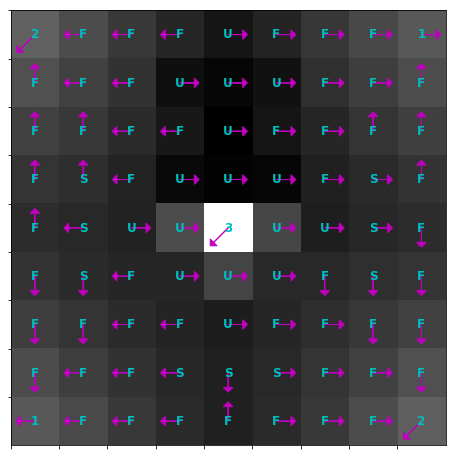

[[0.57928526 0.17274874 0.08041985 0.16754147 0.00000462]
 [0.13254018 0.671049   0.19342697 0.00298386 0.        ]
 [0.07519505 0.20339583 0.5597412  0.16166775 0.00000011]
 [0.18279554 0.00014134 0.15661262 0.6592341  0.0012164 ]
 [0.00004386 0.         0.00003823 0.10489662 0.8950213 ]
 [0.00000559 0.0000001  0.00000187 0.00000367 0.9999888 ]
 [0.04154573 0.00755473 0.04653816 0.03547677 0.86888456]
 [0.06833064 0.01566497 0.07145912 0.05439154 0.79015374]
 [0.01588288 0.00145611 0.02054189 0.02047567 0.9416434 ]
 [0.00000042 0.         0.00000019 0.00002221 0.99997723]]


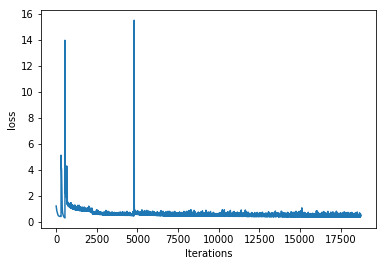

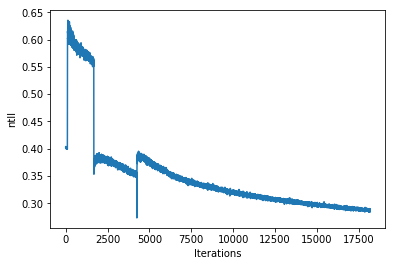

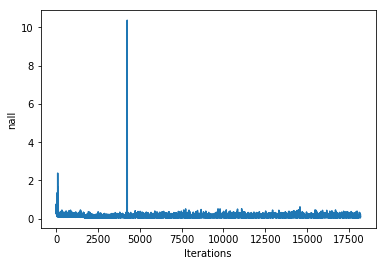

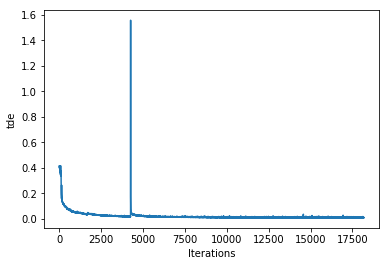

[('ntll', 0.2868999), ('tde', 0.00885759), ('nall', 0.21222909), ('loss', 0.53455937)]
[('ntll', 0.2873185), ('tde', 0.0073932568), ('nall', 0.18029054), ('loss', 0.49718207)]
[('ntll', 0.28582516), ('tde', 0.009783679), ('nall', 0.12943053), ('loss', 0.4543904)]
[('ntll', 0.2854801), ('tde', 0.00746972), ('nall', 0.09390301), ('loss', 0.409262)]
[('ntll', 0.28722167), ('tde', 0.0066778194), ('nall', 0.10026417), ('loss', 0.41419712)]
[('ntll', 0.2865918), ('tde', 0.009429566), ('nall', 0.08692531), ('loss', 0.41123536)]
[('ntll', 0.2862023), ('tde', 0.0066148983), ('nall', 0.108330935), ('loss', 0.42099285)]
[('ntll', 0.28772825), ('tde', 0.0071269767), ('nall', 0.123404644), ('loss', 0.43964082)]


KeyboardInterrupt: 

In [79]:
# Generally I just run this for a bit, then interrupt and switch the update method......................

i = 0
while i < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    t = len(full_train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraints, step=True, update=update, t=t, true_qs=true_qs)        
    if i % 20 == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update=update, t=t, true_qs=true_qs)
        for k, v in train_log.items():
            full_train_logs['%s_evals' % k].append(v)
        for k, v in val_log.items():
            full_train_logs['val_%s_evals' % k].append(v)    
    
    if i % 1000 == 0:
#         print(t, val_log['loss'])
          print([(key,val_log[key]) for key in val_log.keys()])
    if i % 10000 == 0:
        q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
        plot_values(mdp, q_vals)
        plt.show()
        adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]
        print(softmax(adt_probs))
        
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k][10:])
                plt.show()
    i += 1

## Testing Training Results

In [ ]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [ ]:
# Print learned dynamics
softmax(adt_probs)

In [ ]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

In [ ]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

In [ ]:
q_vals - Qs

In [ ]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [ ]:
# More comprehensive debugging stuff

sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]

next_states = [[mdp.sd_to_sprime(s,d) for d in range(mdp.nD)] for s in states]
currQs = Qs[states,acts]
nextQs = Qs[next_states]

pred_probs = true_tps[acts,:,constraints[4].flatten()]

test_err, learned_err, targets = sess.run([test_adt_td_err, adt_td_err_sg, test_adt_target], feed_dict= {constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    test_constraint_q_t_ph: currQs,
                                    test_constraint_q_tp1_ph: nextQs,
                                    test_constraint_adt_pred_probs: pred_probs})
print(test_err, learned_err)

In [ ]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_brsgt_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [ ]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_brgst_invadt.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [ ]:
# Training data Storage
pkl.dump(full_train_logs, open('adt_brsgt.pkl', 'wb'))

## Comparison Tests (NOT UPDATED)

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)

In [ ]:
mdp.get_possible_sprimes(np.array([[0,0],[0,1]]))

In [ ]:
i = 15
mdp.get_direction_moved(nn_rollouts[0][i][0],nn_rollouts[0][i+1][0])

In [ ]:
nn_rollouts[0][i], nn_rollouts[0][i+1]

In [ ]:
nn_rollouts[0][:30]